# Кредитный скоринг

### Выполнил: Земнухов Вадим Тимофеевич

<img src= "https://cronos.asia/wp-content/uploads/2022/02/kreditnyj-skorring.jpeg" width=740, heigth=580>

## Содержание

[**Задание**](#id_1)

[**Разведочный анализ данных**](#id_2)

[**Построение модели, обеспечивающей максимальное значение recall**](#id_3)

[**Построение модели, обеспечивающей максимальное значение f1 (более лояльная к клиентам модель)**](#id_4)

[**Отброс линейно зависимых признаков и проверка лучшей модели**](#id_5)

[**Смешивание моделей Random Forest и CatBoost**](#id_6)

[**Попытка улучшения выбранной модели**](#id_7)

[**Вывод**](#id_8)


<div id= 'id_1'/>

## Задание

Датасет содержит информацию о клиентах некоторого банка.
Задача состоит в том, чтобы по различным характеристикам клиентов спрогнозировать целевую переменную - имел клиент просрочку 90 и более дней или нет (и если имел, то банк не будет выдавать кредит этому клиенту, а иначе будет).

Целевая переменная (таргет) – **SeriousDlqin2yrs:** клиент имел просрочку 90 и более дней

#### Признаки:
- **RevolvingUtilizationOfUnsecuredLines:** общий баланс средств (total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits)


- **age:** возраст заемщика



- **NumberOfTime30-59DaysPastDueNotWorse:** сколько раз за последние 2 года наблюдалась просрочка 30-59 дней


- **DebtRatio:** ежемесячные расходы (платеж по долгам, алиментам, расходы на проживания) деленные на месячный доход


- **MonthlyIncome:** ежемесячный доход


- **NumberOfOpenCreditLinesAndLoans:** количество открытых кредитов (напрмер, автокредит или ипотека) и кредитных карт


- **NumberOfTimes90DaysLate:** сколько раз наблюдалась просрочка (90 и более дней)


- **NumberRealEstateLoansOrLines:** количество кредиов (в том числе под залог жилья)


- **RealEstateLoansOrLines:** закодированное количество кредиов (в том числе под залог жилья) - чем больше код буквы, тем больше кредитов


- **NumberOfTime60-89DaysPastDueNotWorse:** сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней


- **NumberOfDependents:** количество иждивенцев на попечении (супруги, дети и др)


- **GroupAge:** закодированная возрастная группа - чем больше код, тем больше возраст

<div id= 'id_2'/>

## Разведочный анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('credit_scoring.csv')
df.head(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
0,0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0,A,c
1,0,0.602794,25.0,0,0.065868,333.0,2,0,0,0.0,A,b
2,1,0.025656,38.0,0,0.475841,3000.0,7,0,0,2.0,A,c
3,0,0.075427,32.0,0,0.085512,7916.0,6,0,0,0.0,A,b
4,0,0.046560,58.0,0,0.241622,2416.0,9,0,0,0.0,A,d


In [3]:
df.shape

(150000, 12)

Имеем 11 признаков, 150 000 объектов и целевую переменную SeriousDlqin2yrs.

Проверим нашу выборку на наличие дубликатов.

In [4]:
duplicateRows = df[df.duplicated()]
len(duplicateRows)

634

В нашей выборке имеется 634 дубликата. Они будут лишь мешать нашей будущей модели, поэтому удалим их.

In [5]:
df.drop_duplicates(inplace = True)

duplicateRows = df[df.duplicated()]
len(duplicateRows)

0

In [6]:
df.shape

(149366, 12)

Теперь дубликаты отсутствуют. Проанализируем содержимое нашего датасета и некоторые статистики.

In [7]:
df['SeriousDlqin2yrs'].unique()

array([0, 1], dtype=int64)

Имеем 2 целевых класса.

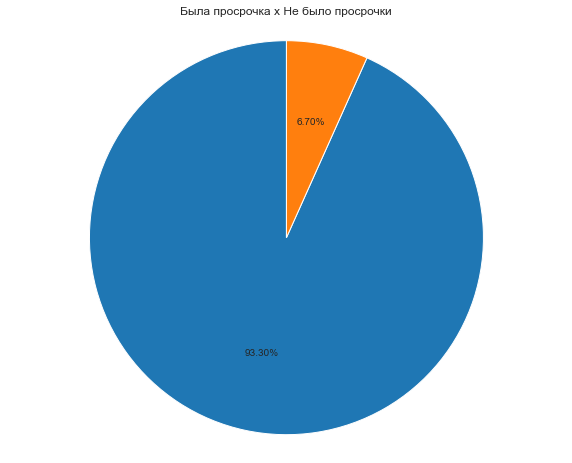

In [8]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
plt.pie(df['SeriousDlqin2yrs'].value_counts(),autopct='%1.2f%%', startangle=90)
plt.axis('equal')
plt.title("Была просрочка x Не было просрочки")
plt.show();

Классы сильно несбалансированны. Количество просрочек сильно меньше, что очень похоже на реальную картину. Следует отметить 2 момента:

- при разбиении выборки на train и test важно сохранить соотношение классов в этих 2 выборках.


- анализ  качества по метрике accuricy в данном случае будет плохим решением. Если в нашем случае модель будет всегда выдавать 0, то метрика accuricy будет иметь значение 0,933. В идеале, для правильного выбора метрики оценки качества нужно знать стратегию банка. Если банк хочет выдавать меньше кредитов тем людям, которые не смогут за него расплатиться, то нужно стремиться к наивысшему значению метрики recall, т.к. в этом случае будет меньше ложноотрицательных ответов. Если же наоборот, банк заинтересован в том, чтобы как можно больше людей брали кредиты (например с целью повышения репутации и др.), и не давать кредиты только тем людям, которые точно за него не смогут расплатиться, то нужно максимизировать метрику precision, но в этом случае будет больше ложноположительных ответов. Компромисным решением будет максимизация метрики f1, как среднегармонического от precision и recall.


- в задании указано, довольно строгое условие: если у человека были просрочки, то банк не выдает кредит, а если не было, то выдает. Принимаем решение, что для оценки качества модели будем использовать метрку recall и будем стремиться к её максимизации.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149366 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149366 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149366 non-null  float64
 2   age                                   134633 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  149366 non-null  int64  
 4   DebtRatio                             149366 non-null  float64
 5   MonthlyIncome                         120171 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149366 non-null  int64  
 7   NumberOfTimes90DaysLate               149366 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  149366 non-null  int64  
 9   NumberOfDependents                    145542 non-null  float64
 10  RealEstateLoansOrLines                149366 non-null  object 
 11  

Признаки *age*, *MonthlyIncome*, *NumberOfDependents* имеют пропуски. Отметим этот момент и чуть позже примем решение о том, какие меры следует предпринять.

После обработки всех пропущенных значений NumberOfDependents и age необходимо перевести в формат int64.

Построим матрицу корреляций прежде, чем начать обрабатывать датасет (для того, чтобы иметь приблизительное представление).

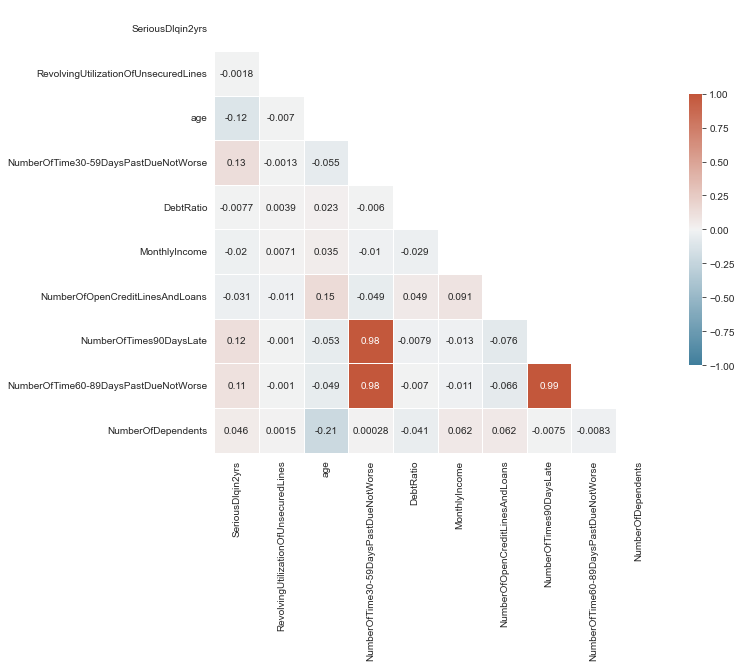

In [10]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           )
plt.show()

Посмотрим на наличие пропусков в датасете.

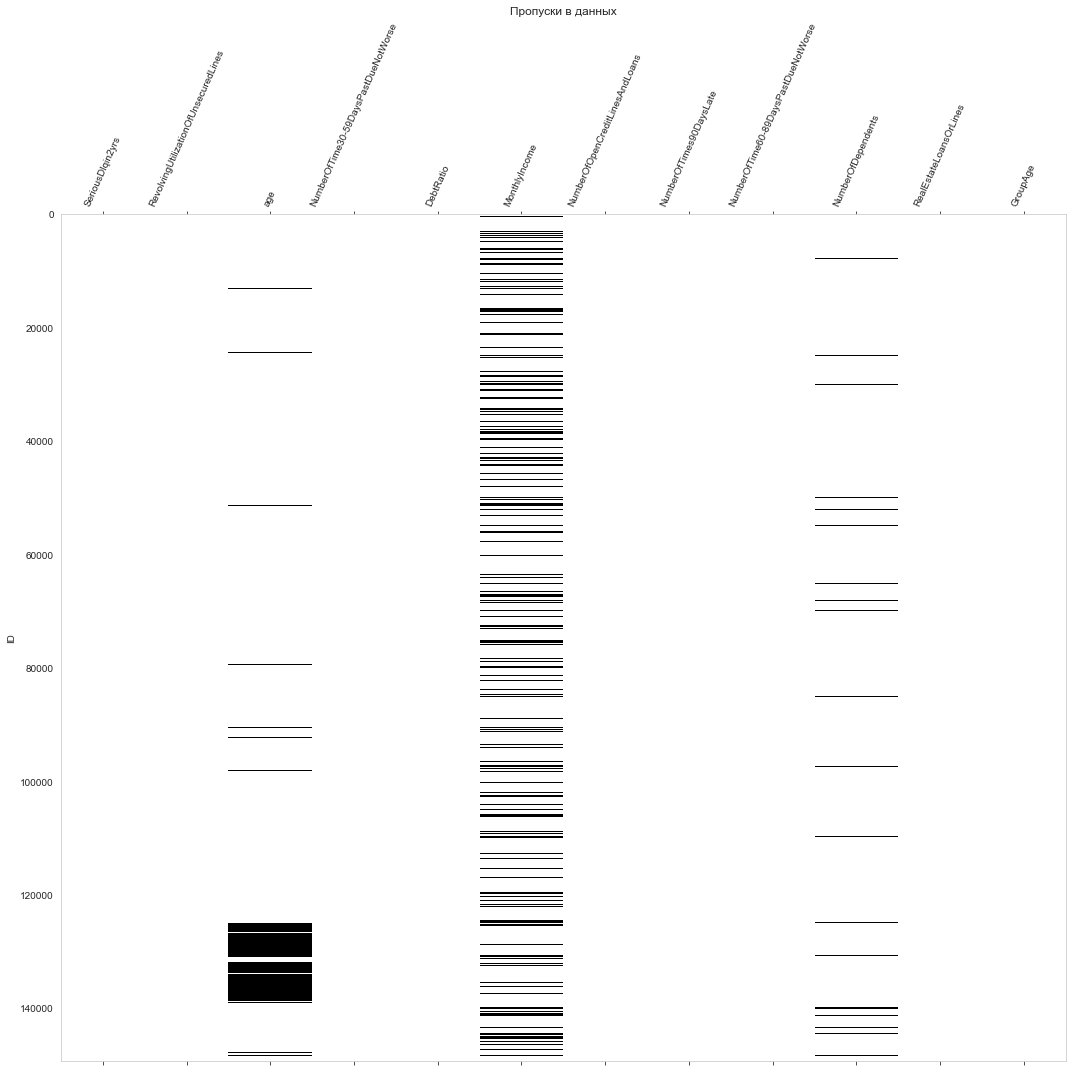

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.spy(df.isnull(), precision=0.0, aspect='auto')

ax.set_xticks(np.arange(len(df.columns)), labels=df.columns, rotation=66)
ax.set_ylabel('ID')
ax.grid(False)

ax.set_title('Пропуски в данных')

fig.tight_layout()
plt.show()

Пропуски в признаке age заполним медианным значением возраста при фильтрации по возрастной категории. Пропуски в остальных признаках необходимо проверять прежде, чем принимать решение.

Проверим объекты с нулевыми значениями.

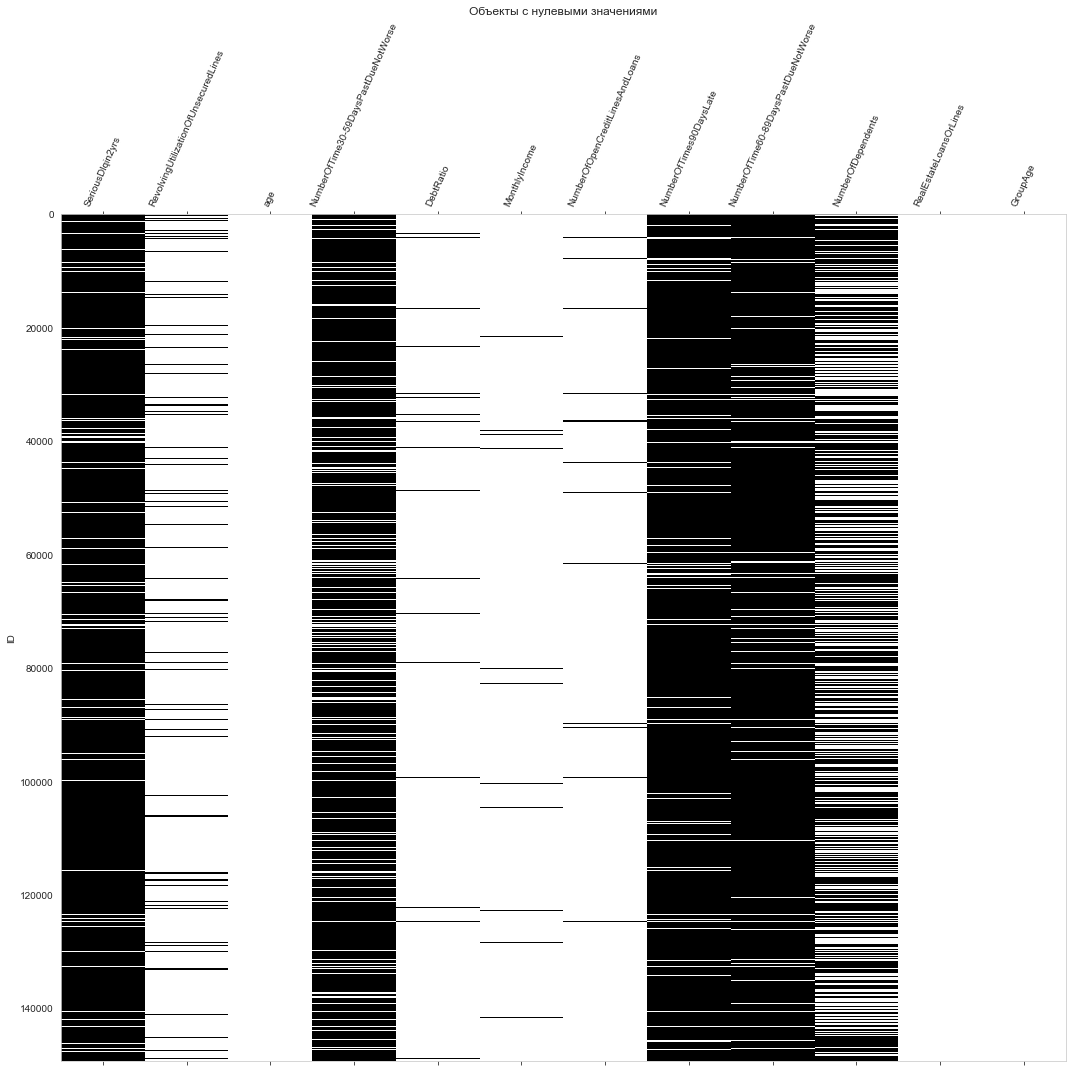

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.spy(df == 0, aspect='auto')

ax.set_xticks(np.arange(len(df.columns)), labels=df.columns, rotation=66)
ax.set_ylabel('ID')
ax.grid(False)

ax.set_title('Объекты с нулевыми значениями')

fig.tight_layout()
plt.show()

In [13]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149366.00000,149366.000000,134633.000000,149366.000000,149366.000000,1.201710e+05,149366.000000,149366.000000,149366.000000,145542.000000
mean,0.06701,6.072049,52.305000,0.395913,354.495057,6.674999e+03,8.481823,0.240075,0.214507,0.759987
std,0.25004,250.284604,14.727369,3.878021,2042.009339,1.438955e+04,5.136322,3.851472,3.835957,1.116188
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.030149,41.000000,0.000000,0.177489,3.400000e+03,5.000000,0.000000,0.000000,0.000000
50%,0.00000,0.154252,52.000000,0.000000,0.368275,5.400000e+03,8.000000,0.000000,0.000000,0.000000
75%,0.00000,0.556480,63.000000,0.000000,0.875333,8.250000e+03,11.000000,0.000000,0.000000,1.000000
max,1.00000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,98.000000,20.000000


In [14]:
df['NumberOfDependents'].unique()

array([ 2.,  0.,  1.,  3., nan,  5.,  4.,  8.,  6.,  7., 10.,  9., 13.,
       20.])

Присутствуют довольно высокие значения количества иждевенцев, что маловероятно в реальной жизни, но тем не менее возможно.

In [15]:
df['age'].unique()

array([ 43.,  25.,  38.,  32.,  58.,  50.,  69.,  53.,  nan,  29.,  54.,
        73.,  61.,  55.,  46.,  57.,  30.,  67.,  62.,  91.,  48.,  64.,
        70.,  37.,  72.,  51.,  75.,  81.,  71.,  44.,  66.,  59.,  31.,
        35.,  60.,  82.,  47.,  40.,  65.,  68.,  63.,  97.,  45.,  49.,
        27.,  28.,  84.,  39.,  26.,  42.,  36.,  33.,  34.,  76.,  52.,
        85.,  74.,  41.,  78.,  56.,  23.,  77.,  87.,  88.,  90.,  86.,
        79.,  80.,  24.,  21.,  83.,  94.,  22.,  93.,  92.,  95.,  89.,
        96.,  99., 107.,  98., 105., 103.,   0., 102., 101., 109.])

Можно заметить довольно большой разброс в возрасте. При этом присутствуют пропуски, которые возможно заполнить, т.к. мы также имеем переменную отвечающую за возрастную категорию. При этом присутствует значение 0, что однозначно является ошибочным, т.к. кредиты могут выдаваться только совершеннолетним людям. 

Также присутствуют довольно большие значения возраста. Бывают люди, которые живут долго, однако, кредиты в более высоком возрасте людям выдают сильно реже. Проверим корректность этих значений при последующем анализе.

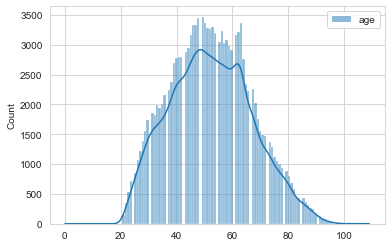

In [16]:
sns.histplot(df[['age']], kde=True)
plt.show();

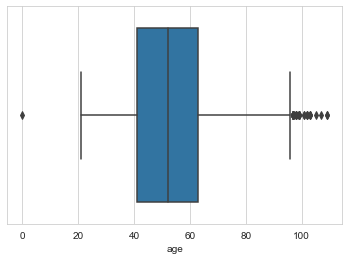

In [17]:
sns.boxplot(x = df['age'])
plt.show();

In [18]:
df[df['age'] > 90]['NumberOfOpenCreditLinesAndLoans'].median()

5.0

In [19]:
df[df['age'] > 90]['NumberOfOpenCreditLinesAndLoans'].mean()

5.563380281690141

In [20]:
df[df['age'] > 90]['GroupAge'].unique()

array(['e'], dtype=object)

Можно заметить, что люди старше 90 лет также могут иметь кредиты. Количество людей в таком возрасте при этом немного. При этом все эти люди относятся к одной возрастной категории в нашем датасете. Оставим эту категорию людей в нашей выборке.

В нашем датасете всего 1 человек, с возрастом 0. Будем считать данное значение ошибочным и удалим его. Но для того, чтобы это сделать без потерь данных для начала заполним пропуски в колонке age.

In [21]:
df[df['age'].isnull()]['GroupAge'].unique()

array(['e'], dtype=object)

In [22]:
df[df['age'].isnull()].shape

(14733, 12)

Все люди с неуказанным возрастом имеют возрастную категорию 'e'. Посмотрим для неё статистики.

In [23]:
df[df['GroupAge'] == 'e']['age'].describe()

count    27919.000000
mean        73.213833
std          6.791443
min         65.000000
25%         68.000000
50%         72.000000
75%         78.000000
max        109.000000
Name: age, dtype: float64

Имеем довольно большое количество пропусков в колонке age. Если заполнить все эти пропуски age медианным значением для данной возрастной категории, то можем получить сильное искажение данных. Построим гистограмму для такого случая.

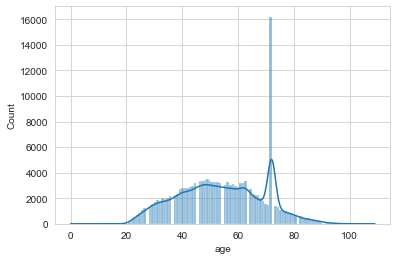

In [24]:
sns.histplot(df['age'].fillna(df[df['GroupAge'] == 'e']['age'].agg('median')), kde=True)
plt.show();

Данная картина явно не отображает реальность и скорее всего будет портить качество модели. Не будем делать данного преобразования.

Проверим сколько людей с пропусками в возрасте имеют просрочки.

In [25]:
df[(df['age'].isnull()) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

999

Классы довольно сильно несбалансированны. Поэтому удаление объектов, которые имеют класс 1 в нашем случае недопустимо. Мы можем удалить те объекты с пропусками в колонке age, для которых значение класса 0, а для остальных попробуем заменить пропуски на медианное значение. Тем самым мы немного сбалансируем наши классы.

In [26]:
df = df[((df['age'].isnull()) & (df['SeriousDlqin2yrs'] == 1)) | (df['age'].isnull() == False)]

In [27]:
df[df['age'].isnull()]['GroupAge'].unique()

array(['e'], dtype=object)

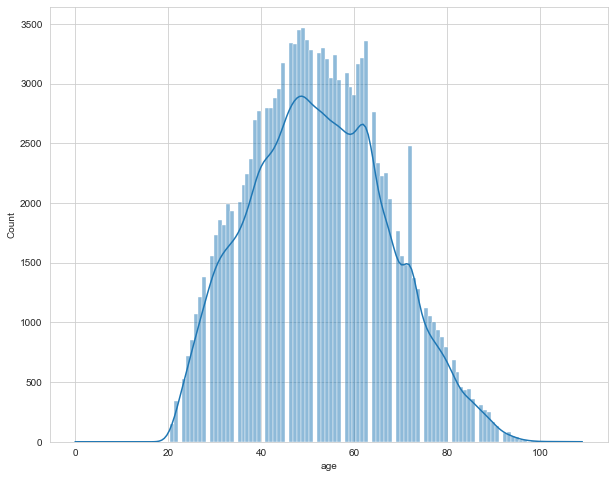

In [28]:
plt.figure(figsize=(10,8))

sns.histplot(df['age'].fillna(df[df['GroupAge'] == 'e']['age'].agg('median')), kde=True)
plt.show();

Теперь можно заметить, что замена на медианный возраст не вносит колоссальных изменений в распределение. Осуществим это в нашем датасете.

In [29]:
df['age'] = df['age'].fillna(df[df['GroupAge'] == 'e']['age'].agg('median'))

In [30]:
df['age'].unique()

array([ 43.,  25.,  38.,  32.,  58.,  50.,  69.,  53.,  29.,  54.,  73.,
        61.,  55.,  46.,  57.,  30.,  67.,  62.,  91.,  48.,  64.,  70.,
        37.,  72.,  51.,  75.,  81.,  71.,  44.,  66.,  59.,  31.,  35.,
        60.,  82.,  47.,  40.,  65.,  68.,  63.,  97.,  45.,  49.,  27.,
        28.,  84.,  39.,  26.,  42.,  36.,  33.,  34.,  76.,  52.,  85.,
        74.,  41.,  78.,  56.,  23.,  77.,  87.,  88.,  90.,  86.,  79.,
        80.,  24.,  21.,  83.,  94.,  22.,  93.,  92.,  95.,  89.,  96.,
        99., 107.,  98., 105., 103.,   0., 102., 101., 109.])

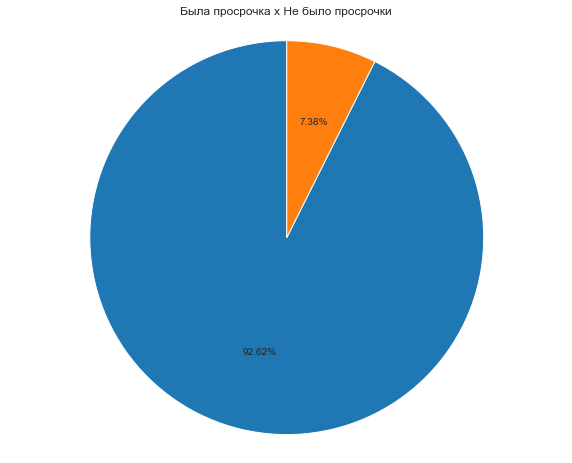

In [31]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
plt.pie(df['SeriousDlqin2yrs'].value_counts(),autopct='%1.2f%%', startangle=90)
plt.axis('equal')
plt.title("Была просрочка x Не было просрочки")
plt.show();

Выборка стала чуть более уравновешенной. Теперь попробуем поработать с выбросами.

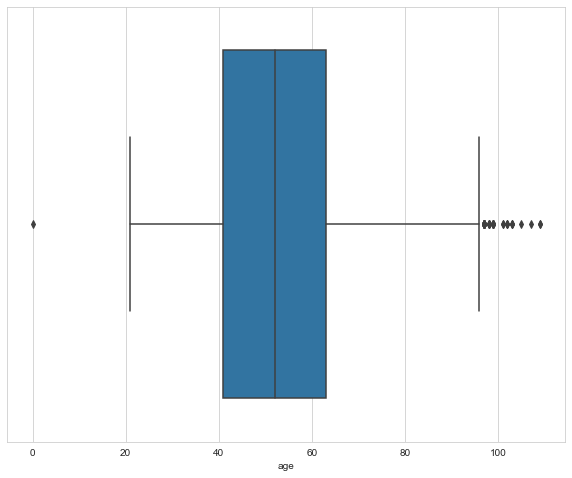

In [32]:
plt.figure(figsize=(10,8))
sns.boxplot(x = df['age'])
plt.show();

Значение возраста 0, явно является ошибочным, т.к. кредит можно выдать лишь совершеннолетнему. Также можно проанализировать значения для очень большого возраста и по возможности удалить те, для которых значение класса 0.

In [33]:
df[df['age'] < 20].shape[0]

1

In [34]:
df[(df['age'] < 20) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

0

In [35]:
df = df[df['age'] > 20]

In [36]:
df[(df['age'] > 100) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

1

In [37]:
df[(df['age'] > 101) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

0

In [38]:
df = df[df['age'] < 101]

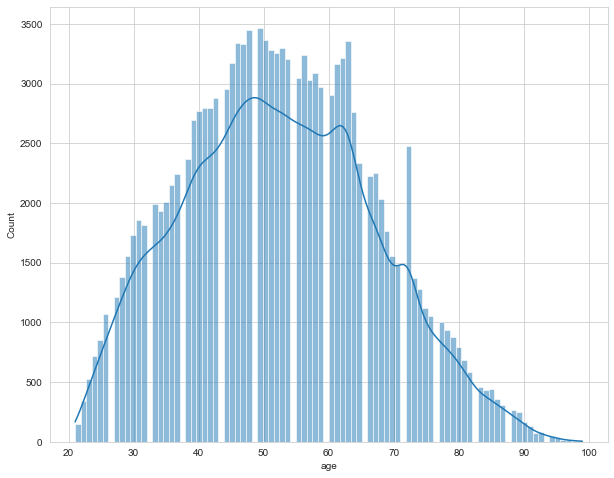

In [39]:
plt.figure(figsize=(10,8))

sns.histplot(df['age'], kde=True)
plt.show();

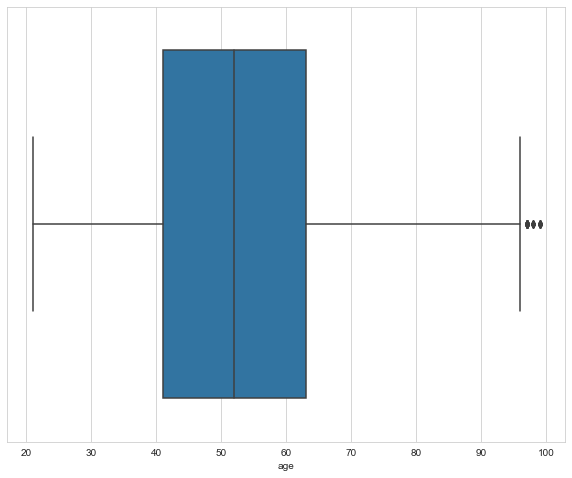

In [40]:
plt.figure(figsize=(10,8))
sns.boxplot(x = df['age'])
plt.show();

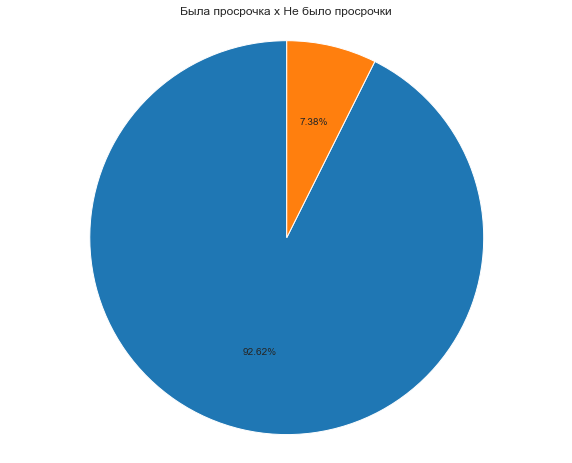

In [41]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
plt.pie(df['SeriousDlqin2yrs'].value_counts(),autopct='%1.2f%%', startangle=90)
plt.axis('equal')
plt.title("Была просрочка x Не было просрочки")
plt.show();

Баланс класснов не изменился, однако, теперь в нашей выборке меньше тех объектов, которые будут сбивать с толку нашу будущую модель.

Проверим, какие уникальные категориальные переменные присутствуют в нашем датасете.

In [42]:
df['RealEstateLoansOrLines'].unique()

array(['A', 'B', 'C', 'E', 'D'], dtype=object)

In [43]:
df['GroupAge'].unique()

array(['c', 'b', 'd', 'e'], dtype=object)

Исходя из условий в исходных данных, *RealEstateLoansOrLines* - это закодированное количество кредиов. При этом, чем больше код буквы, тем больше кредитов. Аналогичая зависимость от кода буквы также присутствует и для переменной *GroupAge*. Отсюда можем сделать вывод, что для кодирования категориальных признаков можем использовать LabelEncoder, однако, наши буквы имеют определенный смысл, поэтому важно правильно их закодировать (a - 1, b - 2 и т.д.). В случае с применением LavelEncoder будет необходимо проверить правильность кодировки. Т.к. у нас не так много категорий, будет проще закодировать категориальные переменные вручную.

In [44]:
df['RealEstateLoansOrLines'] = df['RealEstateLoansOrLines'].str.lower()
to_encode = sorted(df['RealEstateLoansOrLines'].unique())

print(*to_encode)

a b c d e


In [45]:
for i in range(len(to_encode)):
    df.loc[df['RealEstateLoansOrLines'] == to_encode[i], 'RealEstateLoansOrLines'] = i + 1
    df.loc[df['GroupAge'] == to_encode[i], 'GroupAge'] = i + 1

In [46]:
df['RealEstateLoansOrLines'].unique()

array([1, 2, 3, 5, 4], dtype=object)

In [47]:
df['GroupAge'].unique()

array([3, 2, 4, 5], dtype=object)

Проверим, что можно сделать с пропусками для признака NumberOfDependents.

In [48]:
df[df['NumberOfDependents'].isnull()].shape

(3479, 12)

In [49]:
df[df['NumberOfDependents'].isnull()]['GroupAge'].unique()

array([5, 3, 4, 2], dtype=object)

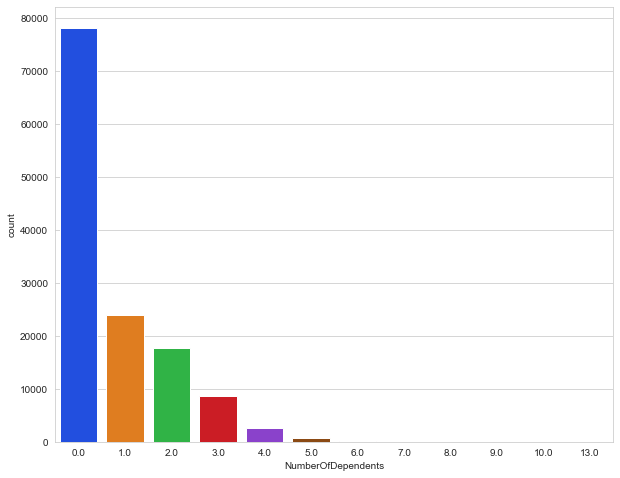

In [50]:
plt.figure(figsize=(10,8))

sns.countplot(x='NumberOfDependents', data = df, palette='bright');

In [51]:
df['NumberOfDependents'].agg('median')

0.0

Посмотрим насколько много людей с пропусками в количестве иждевенцев имеют класс 0.

In [52]:
df[(df['NumberOfDependents'].isnull()) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

178

In [53]:
df[(df['NumberOfDependents'].isnull()) & (df['SeriousDlqin2yrs'] == 0)].shape[0]

3301

In [54]:
df = df[((df['NumberOfDependents'].isnull()) & (df['SeriousDlqin2yrs'] == 1)) | (df['NumberOfDependents'].isnull() == False)]

In [55]:
df[(df['NumberOfDependents'].isnull()) & (df['SeriousDlqin2yrs'] == 0)].shape[0]

0

In [56]:
df[df['NumberOfDependents'].isnull()].groupby(['GroupAge']).agg('count')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines
GroupAge,,,,,,,,,,,
2,49,49,49,49,49,0,49,49,49,0,49
3,36,36,36,36,36,0,36,36,36,0,36
4,56,56,56,56,56,0,56,56,56,0,56
5,37,37,37,37,37,0,37,37,37,0,37


In [57]:
df[df['NumberOfDependents'].isnull()].groupby(['RealEstateLoansOrLines']).agg('count')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,GroupAge
RealEstateLoansOrLines,,,,,,,,,,,
1,169,169,169,169,169,0,169,169,169,0,169
2,7,7,7,7,7,0,7,7,7,0,7
3,1,1,1,1,1,0,1,1,1,0,1
4,1,1,1,1,1,0,1,1,1,0,1


Люди с пропусками в количестве иждивенцев в основном имеют 1 кредит. Возьмем медианное значение количества иждивенцев для этой категории людей.

In [58]:
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(df[df['RealEstateLoansOrLines'] == 1]['NumberOfDependents'].agg('median'))

In [59]:
df[df['NumberOfDependents'].isnull()].shape[0]

0

Теперь посмотрим насколько много людей с довольно большим количеством иждивенцев, что встречается довольно редко, но всё же теоретически возможно.

In [60]:
df[df['NumberOfDependents'] > 3].shape[0]

3507

In [61]:
df[df['NumberOfDependents'] > 4].shape[0]

906

In [62]:
df[df['NumberOfDependents'] > 5].shape[0]

223

Можно заметить, что таких людей немного, однако, именно у них могут быть просрочки по кредиту. Проверим сколько просрочек среди них.

In [63]:
df[(df['NumberOfDependents'] > 4) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

99

In [64]:
df[(df['NumberOfDependents'] > 5) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

31

In [65]:
df[(df['NumberOfDependents'] > 6) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

7

In [66]:
df[(df['NumberOfDependents'] > 7) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

2

In [67]:
df[(df['NumberOfDependents'] > 8) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

0

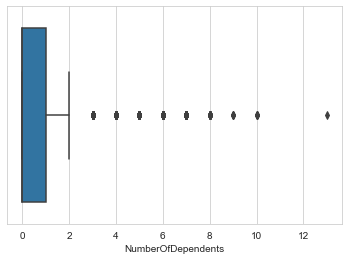

In [68]:
sns.boxplot(x = df['NumberOfDependents'])
plt.show();

Получается, что люди с количеством иждивенцев больше 8 (что уже удивляет) не имеют просрочек по кредиту. Данная ситуация не очень похожа на реальную. Можем удалить из выборки объекты, для которых NumberOfDependents > 8, тем самым мы сделаем наши классы чуть более уравновешенными (хоть и незначительно).

In [69]:
df[df['NumberOfDependents'] > 8].shape[0]

10

Таких объектов всего 10. Выборка уменьшится крайне незначительно.

In [70]:
df = df[df['NumberOfDependents'] < 8]

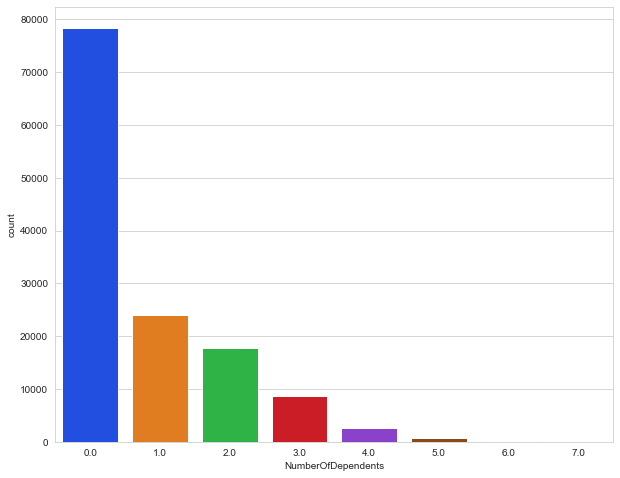

In [71]:
plt.figure(figsize=(10,8))

sns.countplot(x='NumberOfDependents', data = df, palette='bright');

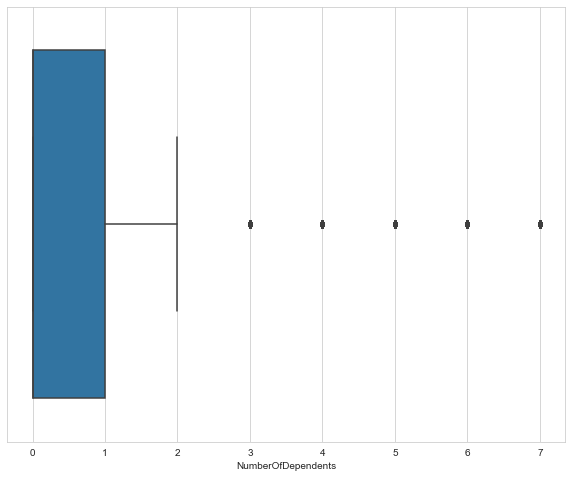

In [72]:
plt.figure(figsize=(10,8))

sns.boxplot(x = df['NumberOfDependents'])
plt.show();

Проверим баланс классов.

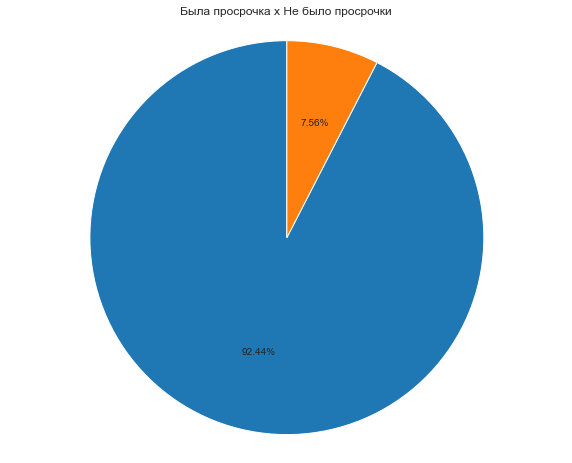

In [73]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
plt.pie(df['SeriousDlqin2yrs'].value_counts(),autopct='%1.2f%%', startangle=90)
plt.axis('equal')
plt.title("Была просрочка x Не было просрочки")
plt.show();

Баланс классов немного улучшился. Посмотрим, что можно сделать с переменной 'MonthlyIncome'.

In [74]:
df[df['MonthlyIncome'].isnull()].shape[0]

23252

Имеем довольно много объектов с неизвестным ежемесячным доходом. Всё-таки ежемесячный доход - это признак, который должен довольно сильно влиять на возможность оплатить кредит.

In [75]:
df[(df['MonthlyIncome'].isnull()) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

1654

Получили, что из большого количества объектов с неуказанным ежемесячным доходом лишь относительно небольшая часть имеет просрочку по кредиту. Удалим объекты с классом 0 и попробуем заполнить медианным значением оставшиеся пропуски. После этого преобразования баланс классов должен сильно улучшиться.

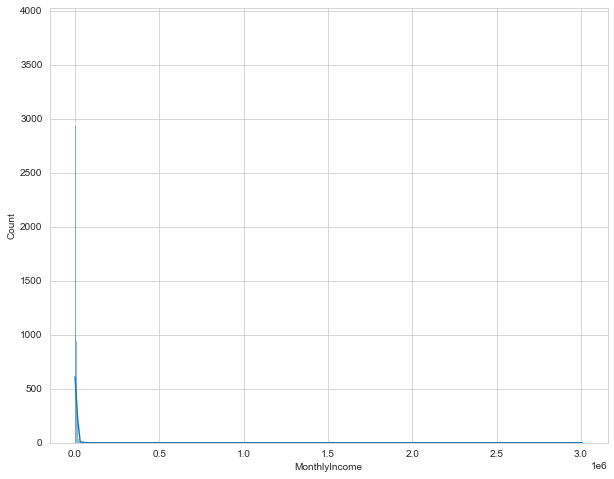

In [76]:
plt.figure(figsize=(10,8))

sns.histplot(df['MonthlyIncome'], kde=True)
plt.show();

Также можно заметить довольно длинный легкий правый хвост гистограммы. Проанализируем это чуть позже.

In [77]:
df = df[((df['MonthlyIncome'].isnull()) & (df['SeriousDlqin2yrs'] == 1)) | ((df['MonthlyIncome'].isnull() == False))]

In [78]:
df[(df['MonthlyIncome'].isnull()) & (df['SeriousDlqin2yrs'] == 0)].shape[0]

0

In [79]:
df[df['MonthlyIncome'].isnull()].groupby(['GroupAge']).agg('count')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines
GroupAge,,,,,,,,,,,
2,345,345,345,345,345,0,345,345,345,345,345
3,560,560,560,560,560,0,560,560,560,560,560
4,467,467,467,467,467,0,467,467,467,467,467
5,282,282,282,282,282,0,282,282,282,282,282


In [80]:
df[df['MonthlyIncome'].isnull()].groupby(['RealEstateLoansOrLines']).agg('count')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,GroupAge
RealEstateLoansOrLines,,,,,,,,,,,
1,1558,1558,1558,1558,1558,0,1558,1558,1558,1558,1558
2,79,79,79,79,79,0,79,79,79,79,79
3,16,16,16,16,16,0,16,16,16,16,16
4,1,1,1,1,1,0,1,1,1,1,1


In [81]:
df[df['MonthlyIncome'].isnull()].groupby(['NumberOfDependents']).agg('count')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,RealEstateLoansOrLines,GroupAge
NumberOfDependents,,,,,,,,,,,
0.0,1365,1365,1365,1365,1365,0,1365,1365,1365,1365,1365
1.0,117,117,117,117,117,0,117,117,117,117,117
2.0,98,98,98,98,98,0,98,98,98,98,98
3.0,45,45,45,45,45,0,45,45,45,45,45
4.0,19,19,19,19,19,0,19,19,19,19,19
5.0,6,6,6,6,6,0,6,6,6,6,6
6.0,4,4,4,4,4,0,4,4,4,4,4


Люди с пропущеными значениями зарплаты в основном имеют 1 кредит и 0 иждивенцев. Посчитаем медианную зарплату для этой категории людей.

In [82]:
df[(df['NumberOfDependents'] == 0) & (df['RealEstateLoansOrLines'] == 1)]['MonthlyIncome'].agg('median')

4583.0

Заполним наши пропуски этим значением.

In [83]:
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(
    df[(df['NumberOfDependents'] == 0) & (df['RealEstateLoansOrLines'] == 1)]['MonthlyIncome'].agg('median'))

Проверим баланс классов целевой переменной.

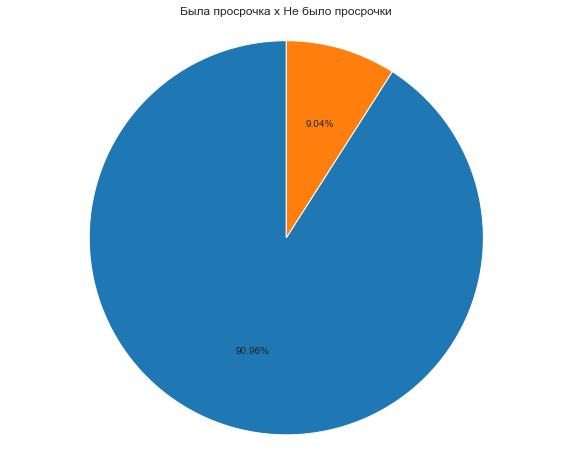

In [84]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
plt.pie(df['SeriousDlqin2yrs'].value_counts(),autopct='%1.2f%%', startangle=90)
plt.axis('equal')
plt.title("Была просрочка x Не было просрочки")
plt.show();

Баланс классов сильно улучшился.

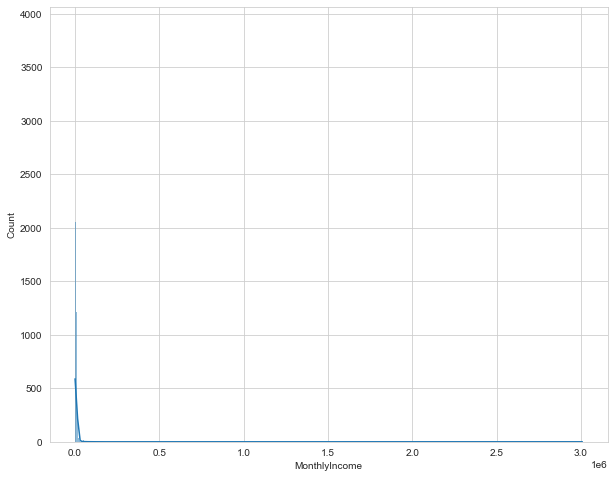

In [85]:
plt.figure(figsize=(10,8))

sns.histplot(df['MonthlyIncome'], kde=True)
plt.show();

Проанализируем выбросы.

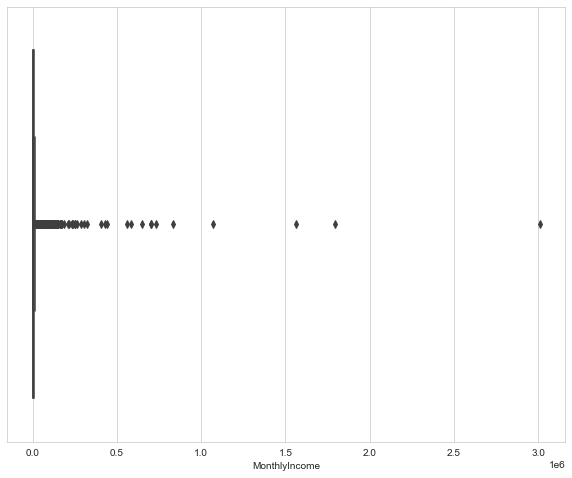

In [86]:
plt.figure(figsize=(10,8))

sns.boxplot(x = df['MonthlyIncome'])
plt.show();

In [87]:
df['MonthlyIncome'].describe()

count    1.106900e+05
mean     6.647203e+03
std      1.474646e+04
min      0.000000e+00
25%      3.441000e+03
50%      5.301000e+03
75%      8.166000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [88]:
df[(df['MonthlyIncome'] > 0.24e+06) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

1

In [89]:
df[(df['MonthlyIncome'] > 0.25e+06) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

0

In [90]:
df[df['MonthlyIncome'] > 0.25e+06].shape[0]

19

In [91]:
df = df[df['MonthlyIncome'] < 0.25e+06]

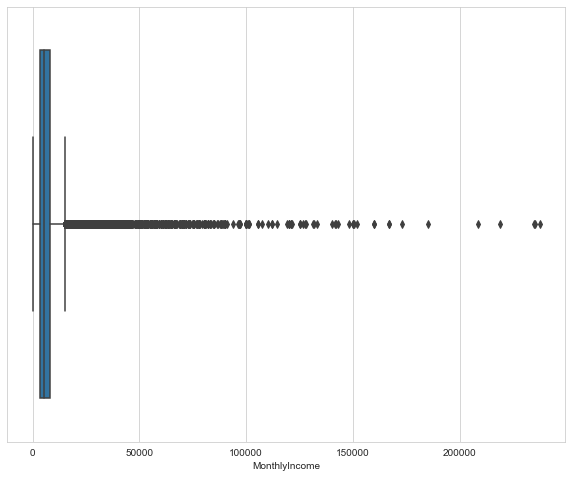

In [92]:
plt.figure(figsize=(10,8))

sns.boxplot(x = df['MonthlyIncome'])
plt.show();

Проверим снова наличие пропусков.

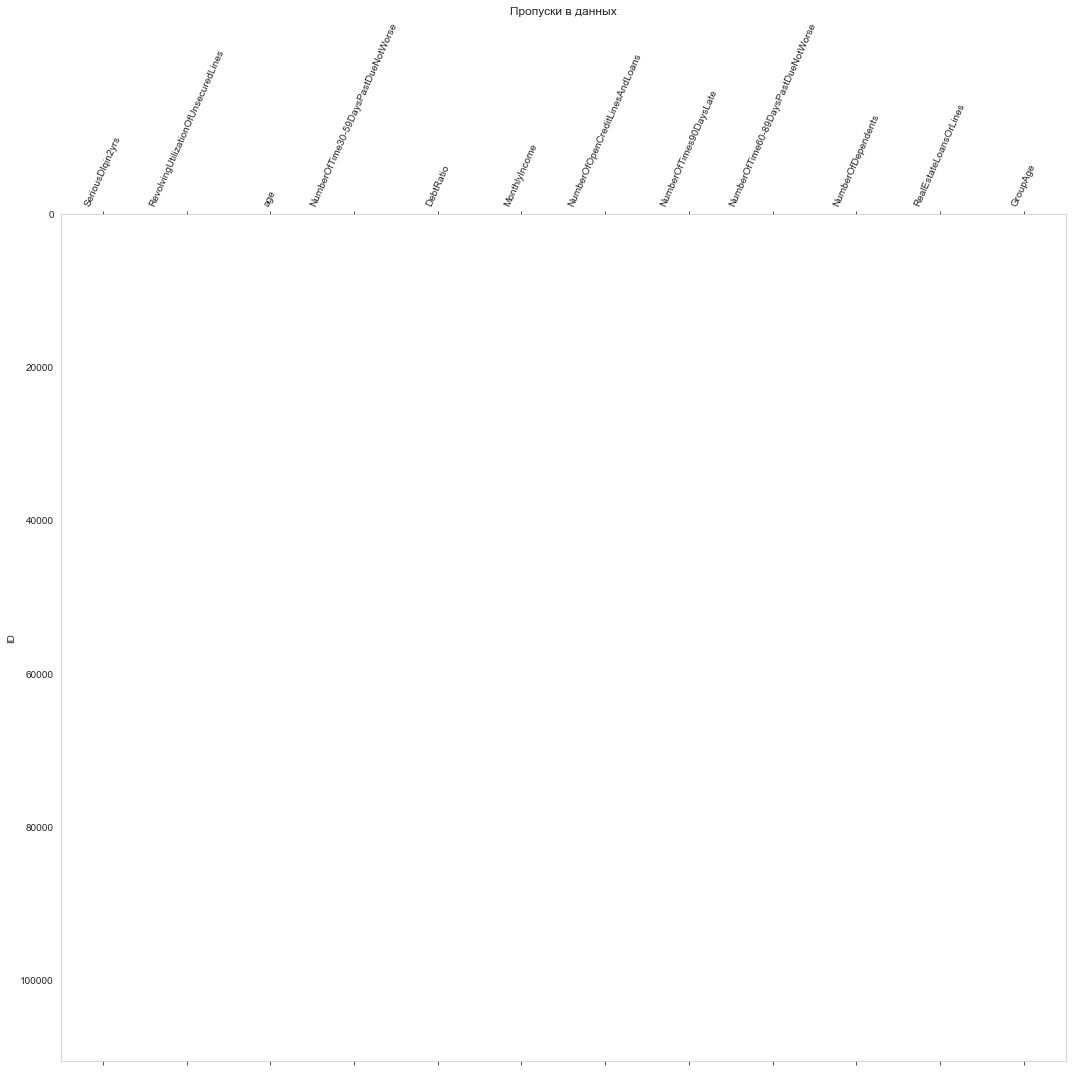

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.spy(df.isnull(), precision=0.0, aspect='auto')

ax.set_xticks(np.arange(len(df.columns)), labels=df.columns, rotation=66)
ax.set_ylabel('ID')
ax.grid(False)

ax.set_title('Пропуски в данных')

fig.tight_layout()
plt.show()

In [94]:
df.shape

(110669, 12)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110669 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      110669 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  110669 non-null  float64
 2   age                                   110669 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  110669 non-null  int64  
 4   DebtRatio                             110669 non-null  float64
 5   MonthlyIncome                         110669 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       110669 non-null  int64  
 7   NumberOfTimes90DaysLate               110669 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  110669 non-null  int64  
 9   NumberOfDependents                    110669 non-null  float64
 10  RealEstateLoansOrLines                110669 non-null  object 
 11  

Пропусков в данных нет. Преобразуем типы данных признаков NumberOfDependents, age в int64.

In [96]:
df['age'] = df['age'].astype('int64')
df['NumberOfDependents'] = df['NumberOfDependents'].astype('int64')
df['RealEstateLoansOrLines'] = df['RealEstateLoansOrLines'].astype('int64')
df['GroupAge'] = df['GroupAge'].astype('int64')

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110669 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      110669 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  110669 non-null  float64
 2   age                                   110669 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  110669 non-null  int64  
 4   DebtRatio                             110669 non-null  float64
 5   MonthlyIncome                         110669 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       110669 non-null  int64  
 7   NumberOfTimes90DaysLate               110669 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  110669 non-null  int64  
 9   NumberOfDependents                    110669 non-null  int64  
 10  RealEstateLoansOrLines                110669 non-null  int64  
 11  

Проанализируем объекты с нулевым значением дохода в месяц. Скорее всего нулевое значение является ошибочным, т.к. банк не выдает кредиты людям без ежемесячного дохода.

In [98]:
df[df['MonthlyIncome'] == 0].shape[0]

1454

In [99]:
df[(df['MonthlyIncome'] == 0)]['DebtRatio'].describe()

count     1454.000000
mean      1601.228336
std       2871.784820
min          0.000000
25%        104.000000
50%        940.000000
75%       2219.250000
max      60212.000000
Name: DebtRatio, dtype: float64

In [100]:
df[(df['MonthlyIncome'] == 0) & (df['SeriousDlqin2yrs'] == 0)].shape[0]

1389

In [101]:
df[(df['MonthlyIncome'] == 0) & (df['SeriousDlqin2yrs'] == 0) & (df['RealEstateLoansOrLines'] > 0)].shape[0]

1389

Большая часть людей с нулевым доходом имеет более одного кредита и при этом не имеет серьезных просрочек, что довольно странно. Скорее всего нулевое значение дохода в нашем датасете является ошибочным. Удалим объекты с нулевым доходом, для которых класс целевой переменной 0.

In [102]:
df = df[(df['MonthlyIncome'] == 0) & (df['SeriousDlqin2yrs'] == 1) | (df['MonthlyIncome'] != 0)]

In [103]:
df[(df['MonthlyIncome'] == 0) & (df['SeriousDlqin2yrs'] == 1)].shape[0]

65

Для остальных 65 объектов поставим уровень дохода равный медианному значению для тех объектов, у которых значение целевой переменной равно 1.

In [104]:
df.loc[df['MonthlyIncome'] == 0, 'MonthlyIncome'] = df[df['SeriousDlqin2yrs'] == 1]['MonthlyIncome'].agg('median')

In [105]:
df[df['MonthlyIncome'] == 0].shape[0]

0

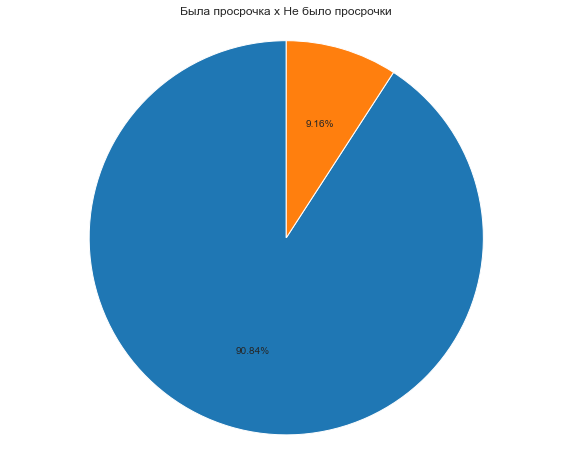

In [106]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
plt.pie(df['SeriousDlqin2yrs'].value_counts(),autopct='%1.2f%%', startangle=90)
plt.axis('equal')
plt.title("Была просрочка x Не было просрочки")
plt.show();

Баланс классов немного улучшился, однако они всё ещё не сбалансированы.

Посмотрим, как изменилась корреляционная матрица.

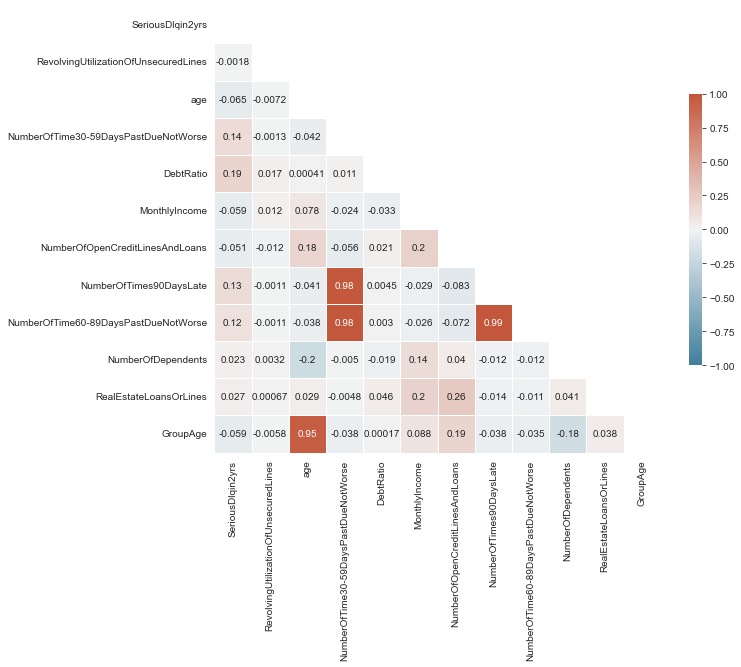

In [107]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           )
plt.show()

Можно заметить, что некоторые признаки имеют очень сильную корреляцию между собой. Пока не будем их удалять. Построим модель для текущего датасета и проанализируем результаты, затем можно будет поэкспериментировать с удаление признаков.

<div id= 'id_3'/>

## Построение модели, обеспечивающей максимальное значение recall

In [108]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [109]:
X = df.drop('SeriousDlqin2yrs', axis = 1)
y = df['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, shuffle=True)

Проверим сохранился ли баланс классов в тренировочной и тестовой выборке.

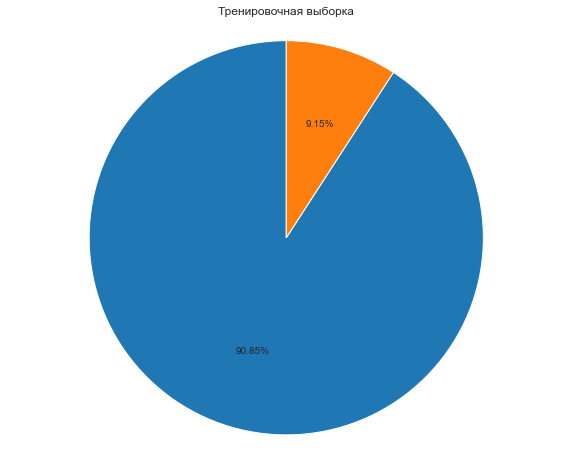

In [110]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
plt.pie(y_train.value_counts(),autopct='%1.2f%%', startangle=90)
plt.axis('equal')
plt.title("Тренировочная выборка")
plt.show();

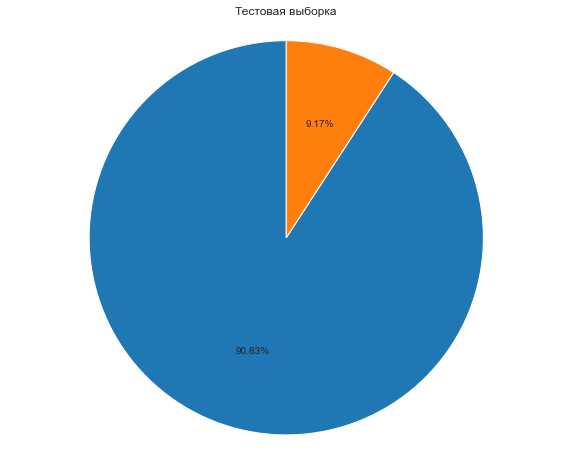

In [111]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
plt.pie(y_test.value_counts(),autopct='%1.2f%%', startangle=90)
plt.axis('equal')
plt.title("Тестовая выборка")
plt.show();

Можно утверждать, что баланс классов сохранился при разбиении.

Выполним масштабирование вещественных признаков.

In [112]:
object = StandardScaler()
X_train.iloc[:, [0, 3, 4]] = object.fit_transform(X_train.iloc[:, [0, 3, 4]])
X_test.iloc[:, [0, 3, 4]] = object.transform(X_test.iloc[:, [0, 3, 4]])

Т.к. нам необходимо достичь наилушчего значения метрики recall, следовательно такой дисбаланс классов нас не устроит. Уйдем от дисбаланса при попощи оверсэмплинга тренировочной выборки.

In [113]:
from imblearn.over_sampling import SMOTE

In [114]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [115]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, counts of label '1': 69498
After OverSampling, counts of label '0': 69498


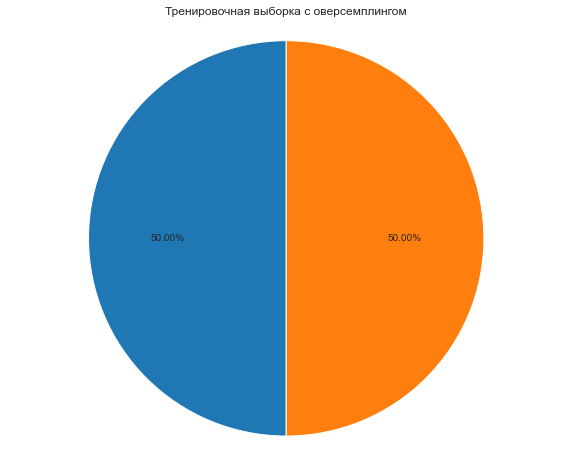

In [116]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
plt.pie([sum(y_train_res == 1), sum(y_train_res == 0)],autopct='%1.2f%%', startangle=90)
plt.axis('equal')
plt.title("Тренировочная выборка с оверсемплингом")
plt.show();

Теперь мы имеем сбалансированные классы. Попробуем несколько классификаторов и выберем наиболее подходящий.

#### Логистическая регрессия

In [120]:
import optuna
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore") 

In [121]:
def print_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

In [225]:
lr = LogisticRegression(random_state = 20)
C = range(1,100)
penalties = ['l2', 'l1', 'elasticnet', None]


param_grid = dict(penalty = penalties, C=C)
grid = GridSearchCV(lr, param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs = -1)

grid.fit(X_train_res, y_train_res)

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.5650951370136353
{'C': 31, 'penalty': 'l2'}
LogisticRegression(C=31, random_state=20)


In [243]:
%%time

lr = LogisticRegression(C = 31, penalty = 'l2', random_state = 20)
lr.fit(X_train_res, y_train_res)
y_pred = lr.predict(X_test)

print_metrics(y_test, y_pred)

accuracy = 0.83
precision = 0.29
recall = 0.63
roc_auc = 0.74
f1 = 0.4
CPU times: total: 4.33 s
Wall time: 926 ms


In [119]:
from sklearn.metrics import classification_report

In [228]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     29777
           1       0.77      0.13      0.22      3007

    accuracy                           0.92     32784
   macro avg       0.84      0.56      0.59     32784
weighted avg       0.90      0.92      0.89     32784



Получили довольно неплохое значение precision, при этом довольно низкое значение recall. Посмотрим, как справятся другие алгоритмы.

#### Стохастический градиентный спуск (SGD)

In [120]:
from sklearn.linear_model import SGDClassifier

In [230]:
sgd = SGDClassifier(random_state = 20)

losses = ["hinge", "modified_huber", "log"]
penalties = ['l2', 'l1', 'elasticnet', None]

param_grid = dict(loss=losses, penalty = penalties)

grid = GridSearchCV(sgd, param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs = -1)
grid.fit(X_train_res, y_train_res)

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6944282974656322
{'loss': 'log', 'penalty': 'elasticnet'}
SGDClassifier(loss='log', penalty='elasticnet')


In [238]:
def objective(trial):

    l1_ratio = trial.suggest_float("l1_ratio", 0.0001, 1, log=True)

    sgd = SGDClassifier(l1_ratio = l1_ratio, loss="log", penalty = "elasticnet", random_state = 20)

    score = cross_val_score(sgd, X_train_res, y_train_res, n_jobs=-1, cv=5, scoring='recall')
    recall = score.mean()
    return recall


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
trial = study.best_trial

[I 2023-06-22 15:18:39,760] A new study created in memory with name: no-name-14ad3b55-999f-4bab-b839-2408a07f3af9
[I 2023-06-22 15:18:46,777] Trial 0 finished with value: 0.7355917640159403 and parameters: {'l1_ratio': 0.001952686266059452}. Best is trial 0 with value: 0.7355917640159403.
[I 2023-06-22 15:18:52,832] Trial 1 finished with value: 0.535660562506179 and parameters: {'l1_ratio': 0.4902812451665384}. Best is trial 0 with value: 0.7355917640159403.
[I 2023-06-22 15:18:59,065] Trial 2 finished with value: 0.5793934484184722 and parameters: {'l1_ratio': 0.003526739989141413}. Best is trial 0 with value: 0.7355917640159403.
[I 2023-06-22 15:19:04,701] Trial 3 finished with value: 0.5357037269385873 and parameters: {'l1_ratio': 0.686123235983591}. Best is trial 0 with value: 0.7355917640159403.
[I 2023-06-22 15:19:10,106] Trial 4 finished with value: 0.681980254259791 and parameters: {'l1_ratio': 0.0011443687973222488}. Best is trial 0 with value: 0.7355917640159403.
[I 2023-06-2

[I 2023-06-22 15:23:05,198] Trial 46 finished with value: 0.5187816037694343 and parameters: {'l1_ratio': 0.0005333543044869895}. Best is trial 0 with value: 0.7355917640159403.
[I 2023-06-22 15:23:10,696] Trial 47 finished with value: 0.6687236191620846 and parameters: {'l1_ratio': 0.0029601054464426673}. Best is trial 0 with value: 0.7355917640159403.
[I 2023-06-22 15:23:16,519] Trial 48 finished with value: 0.5361929510999446 and parameters: {'l1_ratio': 0.00929473573166315}. Best is trial 0 with value: 0.7355917640159403.
[I 2023-06-22 15:23:22,138] Trial 49 finished with value: 0.6818651442756867 and parameters: {'l1_ratio': 0.000747375845597781}. Best is trial 0 with value: 0.7355917640159403.


In [241]:
%%time

sgd = SGDClassifier(loss = 'log', penalty = 'elasticnet', l1_ratio = 0.00195268626605945, random_state = 20)
sgd.fit(X_train_res, y_train_res)
y_pred = sgd.predict(X_test)

print_metrics(y_test, y_pred)

accuracy = 0.1
precision = 0.09
recall = 0.99
roc_auc = 0.5
f1 = 0.17
CPU times: total: 3.89 s
Wall time: 4.03 s


In [242]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.01      0.02     29777
           1       0.09      0.99      0.17      3007

    accuracy                           0.10     32784
   macro avg       0.52      0.50      0.09     32784
weighted avg       0.86      0.10      0.03     32784



Получили хорошее значение метрики recall. Результаты сильно лучше, чем для логистической регрессии. Значение precision довольно низкое, однако в рамках данной задачи нам более важно добиться высокого значения метрики recall, т.к. важнее не выдать кредит заемщику, который теоретически может не расплатиться. В зависимости от изменения политики банка, модель можно корректировать и делать её более лояльной, позволяя осуществалять ложноположительные ответы. В этом случае можно максимизировать метрику f1, чтобы прийти к золотой середине или в случае очень лояльной политики банка можно максимизировать метрику precision. В нашем случае мы строим модель, принимающую жесткие решения в плане выдачи кредитов.

Также стоит обратить внимание на довольно низкое значение accuricy, что немного настораживает. Попробуем другие алгоритмы для решения нашей задачи.

#### Случайный лес

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [244]:
def objective(trial):

    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("max_depth", 2, 50, log=True)
    n_estimators = trial.suggest_int("n_estimators", 2, 1000)
    min_samples_split = trial.suggest_int("min_samples_split", 10, 500, step=1)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 500, step=1)

    rf = RandomForestClassifier(criterion =criterion,
            max_depth=max_depth, 
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            min_samples_leaf = min_samples_leaf,
            random_state = 20
        )

    score = cross_val_score(rf, X_train_res, y_train_res, n_jobs=-1, cv=5, scoring='recall')
    recall = score.mean()
    return recall


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
trial = study.best_trial

[I 2023-06-22 15:33:30,531] A new study created in memory with name: no-name-b2144205-ed18-43fb-807e-e5e3b4906631
[I 2023-06-22 15:34:29,750] Trial 0 finished with value: 0.8078650956204602 and parameters: {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 595, 'min_samples_split': 112, 'min_samples_leaf': 343}. Best is trial 0 with value: 0.8078650956204602.
[I 2023-06-22 15:35:42,642] Trial 1 finished with value: 0.8035627768883533 and parameters: {'criterion': 'gini', 'max_depth': 41, 'n_estimators': 708, 'min_samples_split': 477, 'min_samples_leaf': 316}. Best is trial 0 with value: 0.8078650956204602.
[I 2023-06-22 15:36:10,900] Trial 2 finished with value: 0.8061960112031246 and parameters: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 648, 'min_samples_split': 181, 'min_samples_leaf': 230}. Best is trial 0 with value: 0.8078650956204602.
[I 2023-06-22 15:37:43,265] Trial 3 finished with value: 0.803706685590444 and parameters: {'criterion': 'entropy', 'max_depth': 43

[I 2023-06-22 15:47:52,680] Trial 32 finished with value: 0.8007857156536803 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 333, 'min_samples_split': 147, 'min_samples_leaf': 437}. Best is trial 15 with value: 0.85039857533356.
[I 2023-06-22 15:48:16,983] Trial 33 finished with value: 0.8155775939576421 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 688, 'min_samples_split': 195, 'min_samples_leaf': 57}. Best is trial 15 with value: 0.85039857533356.
[I 2023-06-22 15:48:34,786] Trial 34 finished with value: 0.8030448885872955 and parameters: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 422, 'min_samples_split': 95, 'min_samples_leaf': 165}. Best is trial 15 with value: 0.85039857533356.
[I 2023-06-22 15:49:07,863] Trial 35 finished with value: 0.8046419415298756 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 564, 'min_samples_split': 164, 'min_samples_leaf': 273}. Best is trial 15 with value: 0.85039

In [245]:
%%time

rf = RandomForestClassifier(n_estimators = 90, max_depth = 2, criterion = 'entropy', min_samples_split = 18, 
                            min_samples_leaf = 165, random_state = 20)
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test)

print_metrics(y_test, y_pred)

accuracy = 0.68
precision = 0.2
recall = 0.83
roc_auc = 0.75
f1 = 0.32
CPU times: total: 2.83 s
Wall time: 3.1 s


In [246]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.67      0.79     29777
           1       0.20      0.83      0.32      3007

    accuracy                           0.68     32784
   macro avg       0.59      0.75      0.56     32784
weighted avg       0.90      0.68      0.75     32784



Для случайного леса метрики recall хуже, чем для стохастического градиентного спуска, но при этом в сильно больше значения precision и f1, а также roc_auc и accuricy. Не смотря на то, что метрика recall ниже на мой взгляд модель на основе случайного леса является более предпочтительной и более лояльной по отношению к клиентам.

Посмотрим, какие результаты покажут градиентные бустинги.

#### XGBoost

In [122]:
import xgboost as xgb

In [247]:
def objective(trial):
    
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)
    n_estimators = trial.suggest_int("n_estimators", 2, 500, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 15, log=True)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 30, log=True)
    
    XGB = xgb.XGBClassifier(learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            objective= 'binary:logistic',
                            nthread=-1,
                            scale_pos_weight=1,
                            seed=27,
                            random_state = 20)
    

    score = cross_val_score(XGB, X_train_res, y_train_res, n_jobs=-1, cv=5, scoring='recall')
    recall = score.mean()
    return recall


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
trial = study.best_trial

[I 2023-06-22 15:59:59,299] A new study created in memory with name: no-name-6b84f506-7967-43e6-b250-6ca84f6d375f
[I 2023-06-22 16:01:06,426] Trial 0 finished with value: 0.8124408525844983 and parameters: {'learning_rate': 0.00032939093326919103, 'n_estimators': 265, 'max_depth': 11, 'min_child_weight': 12}. Best is trial 0 with value: 0.8124408525844983.
[I 2023-06-22 16:01:12,820] Trial 1 finished with value: 0.8228438182758347 and parameters: {'learning_rate': 0.02007511054164879, 'n_estimators': 266, 'max_depth': 1, 'min_child_weight': 24}. Best is trial 1 with value: 0.8228438182758347.
[I 2023-06-22 16:01:13,229] Trial 2 finished with value: 0.8685719100954937 and parameters: {'learning_rate': 0.00439974906240969, 'n_estimators': 3, 'max_depth': 2, 'min_child_weight': 2}. Best is trial 2 with value: 0.8685719100954937.
[I 2023-06-22 16:01:20,688] Trial 3 finished with value: 0.8160093469795715 and parameters: {'learning_rate': 0.0011675424573183448, 'n_estimators': 18, 'max_dept

[I 2023-06-22 16:03:18,589] Trial 34 finished with value: 0.8680683057266684 and parameters: {'learning_rate': 0.001144598985945732, 'n_estimators': 3, 'max_depth': 3, 'min_child_weight': 29}. Best is trial 33 with value: 0.8829463110280177.
[I 2023-06-22 16:03:19,419] Trial 35 finished with value: 0.7891881347501322 and parameters: {'learning_rate': 0.00413153427197547, 'n_estimators': 4, 'max_depth': 6, 'min_child_weight': 18}. Best is trial 33 with value: 0.8829463110280177.
[I 2023-06-22 16:03:20,646] Trial 36 finished with value: 0.8135919845172858 and parameters: {'learning_rate': 0.0006152146719088399, 'n_estimators': 3, 'max_depth': 12, 'min_child_weight': 10}. Best is trial 33 with value: 0.8829463110280177.
[I 2023-06-22 16:03:21,226] Trial 37 finished with value: 0.8685719100954937 and parameters: {'learning_rate': 0.0012322081720162468, 'n_estimators': 6, 'max_depth': 2, 'min_child_weight': 16}. Best is trial 33 with value: 0.8829463110280177.
[I 2023-06-22 16:03:22,977] Tr

In [249]:
%%time

XGB = xgb.XGBClassifier(learning_rate=0.0012583369404071108,
                          n_estimators=3,
                          max_depth = 4,
                          min_child_weight = 17,
                          objective= 'binary:logistic',
                          nthread=-1,
                          scale_pos_weight=1,
                          seed=27,
                          random_state = 20)

XGB.fit(X_train_res, y_train_res)
y_pred = XGB.predict(X_test)

print_metrics(y_test, y_pred)

accuracy = 0.63
precision = 0.18
recall = 0.85
roc_auc = 0.73
f1 = 0.29
CPU times: total: 1.67 s
Wall time: 169 ms


In [250]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.60      0.75     29777
           1       0.18      0.85      0.29      3007

    accuracy                           0.63     32784
   macro avg       0.58      0.73      0.52     32784
weighted avg       0.90      0.63      0.70     32784



Получили чуть меньшие значения метрик, по сравнению со случайным лесом.

#### CatBoost

In [123]:
from catboost import CatBoostClassifier

In [254]:
def objective(trial):
    
    depth = trial.suggest_int("depth", 2, 16, log=True)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1, log=True)
    iterations = trial.suggest_int("iterations", 5, 150, log=True)
    
    cat = CatBoostClassifier(depth=depth,
                            learning_rate=learning_rate,
                            iterations=iterations,
                            random_state = 20)
    

    score = cross_val_score(cat, X_train_res, y_train_res, n_jobs=-1, cv=5, scoring='recall')
    recall = score.mean()
    return recall


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
trial = study.best_trial

[I 2023-06-22 16:13:02,173] A new study created in memory with name: no-name-99e140fa-836c-472f-958d-32de0fb3147d
[I 2023-06-22 16:13:07,169] Trial 0 finished with value: 0.8167286285799765 and parameters: {'depth': 6, 'learning_rate': 0.041985685704615416, 'iterations': 66}. Best is trial 0 with value: 0.8167286285799765.
[I 2023-06-22 16:13:10,787] Trial 1 finished with value: 0.8070017200140167 and parameters: {'depth': 13, 'learning_rate': 0.022322378434435273, 'iterations': 8}. Best is trial 0 with value: 0.8167286285799765.
[I 2023-06-22 16:13:12,576] Trial 2 finished with value: 0.8675357142302562 and parameters: {'depth': 3, 'learning_rate': 0.0014960722237861298, 'iterations': 8}. Best is trial 2 with value: 0.8675357142302562.
[I 2023-06-22 16:13:13,628] Trial 3 finished with value: 0.8154335858746631 and parameters: {'depth': 10, 'learning_rate': 0.05294759484054125, 'iterations': 11}. Best is trial 2 with value: 0.8675357142302562.
[I 2023-06-22 16:13:14,312] Trial 4 finish

[I 2023-06-22 16:14:43,714] Trial 39 finished with value: 0.8097930765683158 and parameters: {'depth': 16, 'learning_rate': 0.0015968667595417042, 'iterations': 12}. Best is trial 16 with value: 0.8738094909783374.
[I 2023-06-22 16:14:44,486] Trial 40 finished with value: 0.8125845242217622 and parameters: {'depth': 10, 'learning_rate': 0.011995051809381556, 'iterations': 10}. Best is trial 16 with value: 0.8738094909783374.
[I 2023-06-22 16:14:44,895] Trial 41 finished with value: 0.8727878492371224 and parameters: {'depth': 4, 'learning_rate': 0.0028830232756059206, 'iterations': 8}. Best is trial 16 with value: 0.8738094909783374.
[I 2023-06-22 16:14:45,305] Trial 42 finished with value: 0.8694206125278926 and parameters: {'depth': 3, 'learning_rate': 0.002809452873118356, 'iterations': 6}. Best is trial 16 with value: 0.8738094909783374.
[I 2023-06-22 16:14:45,741] Trial 43 finished with value: 0.8738094909783374 and parameters: {'depth': 4, 'learning_rate': 0.0020473179078190143, 

In [255]:
%%time

cat = CatBoostClassifier(depth=4,
                            learning_rate=0.0029741384415727717,
                            iterations=7,
                            random_state = 20)

cat.fit(X_train_res, y_train_res)
y_pred = cat.predict(X_test)

print_metrics(y_test, y_pred)

0:	learn: 0.6921265	total: 153ms	remaining: 918ms
1:	learn: 0.6911113	total: 160ms	remaining: 399ms
2:	learn: 0.6900942	total: 165ms	remaining: 219ms
3:	learn: 0.6890879	total: 170ms	remaining: 127ms
4:	learn: 0.6881059	total: 174ms	remaining: 69.6ms
5:	learn: 0.6870940	total: 178ms	remaining: 29.7ms
6:	learn: 0.6861174	total: 183ms	remaining: 0us
accuracy = 0.64
precision = 0.19
recall = 0.86
roc_auc = 0.74
f1 = 0.31
CPU times: total: 109 ms
Wall time: 307 ms


In [256]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.62      0.76     29777
           1       0.19      0.86      0.31      3007

    accuracy                           0.64     32784
   macro avg       0.58      0.74      0.53     32784
weighted avg       0.91      0.64      0.72     32784



При помощи CatBoost получили значения метрик эквивалентные случайному лесу.

После того, как мы опробовали некоторые классификаторы можно заметить, что предпочтение по максимизации метрики recall можно отдать Random Forest и CatBoost.

При этом стоит отметить, что наши модели лояльны скорее банку, чем клиенту, т.к. у них будет наблюдаться довольно большое количество ложноположительных срабатываний. Попробуем построить несколько других моделей, которые будут являться золотой серединой. Для них мы будет максимизировать метрику f1.

<div id= 'id_4'/>

## Построение модели, обеспечивающей максимальное значение f1 (более лояльная к клиентам модель)

#### Логистическая регрессия

In [257]:
lr_2 = LogisticRegression(random_state = 20)
C = range(1,100)
penalties = ['l2', 'l1', 'elasticnet', None]


param_grid = dict(penalty = penalties, C=C)
grid = GridSearchCV(lr_2, param_grid, cv=5, scoring='f1', return_train_score=True, n_jobs = -1)

grid.fit(X_train_res, y_train_res)

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6562630437117447
{'C': 86, 'penalty': 'l2'}
LogisticRegression(C=86, random_state=20)


In [260]:
%%time

lr_2 = LogisticRegression(C = 86, penalty = 'l2', random_state = 20)
lr_2.fit(X_train_res, y_train_res)
y_pred = lr_2.predict(X_test)

print_metrics(y_test, y_pred)

accuracy = 0.82
precision = 0.29
recall = 0.63
roc_auc = 0.74
f1 = 0.39
CPU times: total: 4.39 s
Wall time: 943 ms


In [261]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90     29777
           1       0.29      0.63      0.39      3007

    accuracy                           0.82     32784
   macro avg       0.62      0.74      0.65     32784
weighted avg       0.90      0.82      0.85     32784



Метрики логистической регрессии неудовлетворительны.

#### Стохастический градиентный спуск (SGD)

In [262]:
sgd_2 = SGDClassifier(random_state = 20)

losses = ["hinge", "modified_huber", "log"]
penalties = ['l2', 'l1', 'elasticnet', None]

param_grid = dict(loss=losses, penalty = penalties)

grid = GridSearchCV(sgd_2, param_grid, cv=5, scoring='f1', return_train_score=True, n_jobs = -1)
grid.fit(X_train_res, y_train_res)

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6872793613202219
{'loss': 'log', 'penalty': None}
SGDClassifier(loss='log', penalty=None, random_state=20)


In [263]:
%%time

sgd_2 = SGDClassifier(loss = 'log', penalty = None, random_state = 20)
sgd_2.fit(X_train_res, y_train_res)
y_pred = sgd_2.predict(X_test)

print_metrics(y_test, y_pred)

accuracy = 0.88
precision = 0.36
recall = 0.47
roc_auc = 0.69
f1 = 0.41
CPU times: total: 10.2 s
Wall time: 10.7 s


In [264]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     29777
           1       0.36      0.47      0.41      3007

    accuracy                           0.88     32784
   macro avg       0.65      0.69      0.67     32784
weighted avg       0.89      0.88      0.88     32784



Для SGD получили довольно низкие значения метрик recall и precision. Такая модель нам не подойдет.

#### Случайный лес

In [265]:
def objective(trial):

    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("max_depth", 2, 50, log=True)
    n_estimators = trial.suggest_int("n_estimators", 2, 1000)
    min_samples_split = trial.suggest_int("min_samples_split", 10, 500, step=1)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 500, step=1)

    rf_2 = RandomForestClassifier(criterion =criterion,
            max_depth=max_depth, 
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            min_samples_leaf = min_samples_leaf,
            random_state = 20
        )

    score = cross_val_score(rf_2, X_train_res, y_train_res, n_jobs=-1, cv=5, scoring='f1')
    f1 = score.mean()
    return f1


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
trial = study.best_trial

[I 2023-06-22 16:43:58,399] A new study created in memory with name: no-name-f19320ba-41c6-493e-828e-d17df9d971d2
[I 2023-06-22 16:44:45,577] Trial 0 finished with value: 0.7808313996884539 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 551, 'min_samples_split': 265, 'min_samples_leaf': 289}. Best is trial 0 with value: 0.7808313996884539.
[I 2023-06-22 16:44:50,782] Trial 1 finished with value: 0.7735301154011789 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 76, 'min_samples_split': 340, 'min_samples_leaf': 43}. Best is trial 0 with value: 0.7808313996884539.
[I 2023-06-22 16:44:58,082] Trial 2 finished with value: 0.7902454990743897 and parameters: {'criterion': 'gini', 'max_depth': 34, 'n_estimators': 63, 'min_samples_split': 22, 'min_samples_leaf': 491}. Best is trial 2 with value: 0.7902454990743897.
[I 2023-06-22 16:45:01,395] Trial 3 finished with value: 0.7941497531384784 and parameters: {'criterion': 'gini', 'max_depth': 41,

[I 2023-06-22 17:14:06,602] Trial 33 finished with value: 0.8089256525092413 and parameters: {'criterion': 'gini', 'max_depth': 38, 'n_estimators': 591, 'min_samples_split': 211, 'min_samples_leaf': 40}. Best is trial 33 with value: 0.8089256525092413.
[I 2023-06-22 17:15:16,258] Trial 34 finished with value: 0.8075785234632228 and parameters: {'criterion': 'gini', 'max_depth': 41, 'n_estimators': 576, 'min_samples_split': 257, 'min_samples_leaf': 38}. Best is trial 33 with value: 0.8089256525092413.
[I 2023-06-22 17:16:28,890] Trial 35 finished with value: 0.8080683456697064 and parameters: {'criterion': 'gini', 'max_depth': 39, 'n_estimators': 598, 'min_samples_split': 249, 'min_samples_leaf': 34}. Best is trial 33 with value: 0.8089256525092413.
[I 2023-06-22 17:18:10,677] Trial 36 finished with value: 0.8067212604168384 and parameters: {'criterion': 'entropy', 'max_depth': 39, 'n_estimators': 702, 'min_samples_split': 313, 'min_samples_leaf': 38}. Best is trial 33 with value: 0.808

In [266]:
%%time

rf_2 = RandomForestClassifier(n_estimators = 646, max_depth = 19, criterion = 'entropy', min_samples_split = 101, 
                            min_samples_leaf = 15, random_state = 20)
rf_2.fit(X_train_res, y_train_res)
y_pred = rf_2.predict(X_test)

print_metrics(y_test, y_pred)

accuracy = 0.81
precision = 0.29
recall = 0.75
roc_auc = 0.78
f1 = 0.42
CPU times: total: 1min 39s
Wall time: 1min 41s


In [267]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88     29777
           1       0.29      0.75      0.42      3007

    accuracy                           0.81     32784
   macro avg       0.63      0.78      0.65     32784
weighted avg       0.91      0.81      0.84     32784



Получили довольно оптимальное качество модели. Метрика recall имеет по-прежнему приемлемое значение, однако при этом precision и как следствие f1 уже ощутимо выше, если сравнивать с моделями, в которых мы максимизировались по recall. При этом accuricy составляет 0.81. Для модели случайного леса, в которой максимизация была по recall метрика accuricy принимала значение 0.68.

#### XGBoost

In [268]:
def objective(trial):
    
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)
    n_estimators = trial.suggest_int("n_estimators", 2, 500, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 15, log=True)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 30, log=True)
    
    XGB_2 = xgb.XGBClassifier(learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            objective= 'binary:logistic',
                            nthread=-1,
                            scale_pos_weight=1,
                            seed=27,
                            random_state = 20)
    

    score = cross_val_score(XGB_2, X_train_res, y_train_res, n_jobs=-1, cv=5, scoring='f1')
    f1 = score.mean()
    return f1


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
trial = study.best_trial

[I 2023-06-22 17:42:09,597] A new study created in memory with name: no-name-42e0f138-6022-452c-b3fb-3ba204355187
[I 2023-06-22 17:42:17,344] Trial 0 finished with value: 0.7905397554752781 and parameters: {'learning_rate': 0.019861046223383597, 'n_estimators': 42, 'max_depth': 7, 'min_child_weight': 5}. Best is trial 0 with value: 0.7905397554752781.
[I 2023-06-22 17:42:18,696] Trial 1 finished with value: 0.7724245485729073 and parameters: {'learning_rate': 0.010322174458833315, 'n_estimators': 2, 'max_depth': 2, 'min_child_weight': 30}. Best is trial 0 with value: 0.7905397554752781.
[I 2023-06-22 17:42:21,346] Trial 2 finished with value: 0.7578034712647934 and parameters: {'learning_rate': 0.001566329219538858, 'n_estimators': 65, 'max_depth': 1, 'min_child_weight': 19}. Best is trial 0 with value: 0.7905397554752781.
[I 2023-06-22 17:42:22,169] Trial 3 finished with value: 0.7724245485729073 and parameters: {'learning_rate': 0.000181559327835889, 'n_estimators': 13, 'max_depth': 

[I 2023-06-22 17:58:19,681] Trial 34 finished with value: 0.8701986919755637 and parameters: {'learning_rate': 0.09717878139160135, 'n_estimators': 231, 'max_depth': 12, 'min_child_weight': 5}. Best is trial 34 with value: 0.8701986919755637.
[I 2023-06-22 17:59:22,269] Trial 35 finished with value: 0.8691103564956002 and parameters: {'learning_rate': 0.09836573258215124, 'n_estimators': 234, 'max_depth': 13, 'min_child_weight': 8}. Best is trial 34 with value: 0.8701986919755637.
[I 2023-06-22 17:59:52,990] Trial 36 finished with value: 0.8466025135806868 and parameters: {'learning_rate': 0.09206701285568669, 'n_estimators': 124, 'max_depth': 12, 'min_child_weight': 13}. Best is trial 34 with value: 0.8701986919755637.
[I 2023-06-22 18:00:49,774] Trial 37 finished with value: 0.858816575541454 and parameters: {'learning_rate': 0.0665019529062018, 'n_estimators': 229, 'max_depth': 12, 'min_child_weight': 8}. Best is trial 34 with value: 0.8701986919755637.
[I 2023-06-22 18:01:31,913] T

[I 2023-06-22 18:39:57,704] Trial 68 finished with value: 0.8462426186463426 and parameters: {'learning_rate': 0.04006250328944358, 'n_estimators': 393, 'max_depth': 10, 'min_child_weight': 14}. Best is trial 61 with value: 0.8761409995648703.
[I 2023-06-22 18:41:31,903] Trial 69 finished with value: 0.8660803834886499 and parameters: {'learning_rate': 0.055169055062074736, 'n_estimators': 331, 'max_depth': 14, 'min_child_weight': 10}. Best is trial 61 with value: 0.8761409995648703.
[I 2023-06-22 18:42:44,352] Trial 70 finished with value: 0.8542455905416118 and parameters: {'learning_rate': 0.08120544505853446, 'n_estimators': 422, 'max_depth': 9, 'min_child_weight': 19}. Best is trial 61 with value: 0.8761409995648703.
[I 2023-06-22 18:44:15,843] Trial 71 finished with value: 0.8719949079556157 and parameters: {'learning_rate': 0.0999291135445865, 'n_estimators': 309, 'max_depth': 15, 'min_child_weight': 13}. Best is trial 61 with value: 0.8761409995648703.
[I 2023-06-22 18:45:25,01

In [269]:
%%time

XGB_2 = xgb.XGBClassifier(learning_rate=0.08855916642815341,
                          n_estimators=441,
                          max_depth = 14,
                          min_child_weight = 9,
                          objective= 'binary:logistic',
                          nthread=-1,
                          scale_pos_weight=1,
                          seed=27,
                          random_state = 20)

XGB_2.fit(X_train_res, y_train_res)
y_pred = XGB_2.predict(X_test)

print_metrics(y_test, y_pred)

accuracy = 0.85
precision = 0.33
recall = 0.58
roc_auc = 0.73
f1 = 0.42
CPU times: total: 6min 44s
Wall time: 35.4 s


In [270]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92     29777
           1       0.33      0.58      0.42      3007

    accuracy                           0.85     32784
   macro avg       0.64      0.73      0.67     32784
weighted avg       0.90      0.85      0.87     32784



Получили качество заметно хуже, чем для алгоритма Random Forest.

#### CatBoost

In [273]:
def objective(trial):
    
    depth = trial.suggest_int("depth", 2, 16, log=True)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1, log=True)
    iterations = trial.suggest_int("iterations", 5, 150, log=True)
    
    cat_2 = CatBoostClassifier(depth=depth,
                            learning_rate=learning_rate,
                            iterations=iterations,
                            random_state = 20)
    

    score = cross_val_score(cat_2, X_train_res, y_train_res, n_jobs=-1, cv=5, scoring='f1')
    f1 = score.mean()
    return f1


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
trial = study.best_trial

[I 2023-06-22 19:41:33,579] A new study created in memory with name: no-name-9ea9438c-4041-4e3e-9117-98042dd083da
[I 2023-06-22 19:41:37,366] Trial 0 finished with value: 0.7880390428478479 and parameters: {'depth': 11, 'learning_rate': 0.030108734752713716, 'iterations': 7}. Best is trial 0 with value: 0.7880390428478479.
[I 2023-06-22 19:41:39,977] Trial 1 finished with value: 0.7717953905483704 and parameters: {'depth': 2, 'learning_rate': 0.007101408729759538, 'iterations': 96}. Best is trial 0 with value: 0.7880390428478479.
[I 2023-06-22 19:41:45,034] Trial 2 finished with value: 0.7987050147796094 and parameters: {'depth': 9, 'learning_rate': 0.018336796687587167, 'iterations': 138}. Best is trial 2 with value: 0.7987050147796094.
[I 2023-06-22 19:42:13,515] Trial 3 finished with value: 0.8074297637239607 and parameters: {'depth': 15, 'learning_rate': 0.06965810017554278, 'iterations': 35}. Best is trial 3 with value: 0.8074297637239607.
[I 2023-06-22 19:42:14,283] Trial 4 finis

[I 2023-06-22 19:53:01,761] Trial 39 finished with value: 0.8122791418488372 and parameters: {'depth': 15, 'learning_rate': 0.05217423874631401, 'iterations': 73}. Best is trial 33 with value: 0.8138600631234937.
[I 2023-06-22 19:53:03,062] Trial 40 finished with value: 0.7754179089764427 and parameters: {'depth': 2, 'learning_rate': 0.025694854580621828, 'iterations': 86}. Best is trial 33 with value: 0.8138600631234937.
[I 2023-06-22 19:53:49,838] Trial 41 finished with value: 0.8106960084933057 and parameters: {'depth': 15, 'learning_rate': 0.05228581970300018, 'iterations': 60}. Best is trial 33 with value: 0.8138600631234937.
[I 2023-06-22 19:55:23,193] Trial 42 finished with value: 0.8126600953824106 and parameters: {'depth': 16, 'learning_rate': 0.0486188656124106, 'iterations': 62}. Best is trial 33 with value: 0.8138600631234937.
[I 2023-06-22 19:57:44,890] Trial 43 finished with value: 0.8140977697693401 and parameters: {'depth': 16, 'learning_rate': 0.03759696717908322, 'ite

[I 2023-06-22 20:24:26,112] Trial 78 finished with value: 0.82698486306886 and parameters: {'depth': 15, 'learning_rate': 0.09888331177988027, 'iterations': 98}. Best is trial 69 with value: 0.8330626988782089.
[I 2023-06-22 20:25:38,726] Trial 79 finished with value: 0.8261693495089654 and parameters: {'depth': 15, 'learning_rate': 0.09879518325186466, 'iterations': 96}. Best is trial 69 with value: 0.8330626988782089.
[I 2023-06-22 20:26:06,002] Trial 80 finished with value: 0.8167484986876634 and parameters: {'depth': 13, 'learning_rate': 0.05560374416084102, 'iterations': 130}. Best is trial 69 with value: 0.8330626988782089.
[I 2023-06-22 20:26:51,089] Trial 81 finished with value: 0.826774507120071 and parameters: {'depth': 14, 'learning_rate': 0.0972168293395471, 'iterations': 116}. Best is trial 69 with value: 0.8330626988782089.
[I 2023-06-22 20:27:59,391] Trial 82 finished with value: 0.8199099917206144 and parameters: {'depth': 15, 'learning_rate': 0.07644500103335557, 'iter

In [274]:
%%time

cat_2 = CatBoostClassifier(depth=16,
                            learning_rate=0.0871931848502654,
                            iterations=135,
                            random_state = 20)

cat_2.fit(X_train_res, y_train_res)
y_pred = cat_2.predict(X_test)

print_metrics(y_test, y_pred)

0:	learn: 0.6603289	total: 662ms	remaining: 1m 28s
1:	learn: 0.6311907	total: 1.32s	remaining: 1m 27s
2:	learn: 0.6072347	total: 1.96s	remaining: 1m 26s
3:	learn: 0.5851623	total: 2.61s	remaining: 1m 25s
4:	learn: 0.5668233	total: 3.25s	remaining: 1m 24s
5:	learn: 0.5502782	total: 3.93s	remaining: 1m 24s
6:	learn: 0.5357906	total: 4.6s	remaining: 1m 24s
7:	learn: 0.5225867	total: 5.26s	remaining: 1m 23s
8:	learn: 0.5111918	total: 5.92s	remaining: 1m 22s
9:	learn: 0.5010950	total: 6.55s	remaining: 1m 21s
10:	learn: 0.4920064	total: 7.2s	remaining: 1m 21s
11:	learn: 0.4836788	total: 7.85s	remaining: 1m 20s
12:	learn: 0.4762105	total: 8.48s	remaining: 1m 19s
13:	learn: 0.4687157	total: 9.13s	remaining: 1m 18s
14:	learn: 0.4622532	total: 9.79s	remaining: 1m 18s
15:	learn: 0.4563082	total: 10.5s	remaining: 1m 17s
16:	learn: 0.4506492	total: 11.1s	remaining: 1m 16s
17:	learn: 0.4459557	total: 11.7s	remaining: 1m 16s
18:	learn: 0.4414269	total: 12.4s	remaining: 1m 15s
19:	learn: 0.4371584	tot

In [275]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89     29777
           1       0.30      0.71      0.42      3007

    accuracy                           0.82     32784
   macro avg       0.63      0.77      0.66     32784
weighted avg       0.90      0.82      0.85     32784



Получили качество модели, эквивалентное случайному лесу.

<div id= 'id_5'/>

## Отброс линейно зависимых признаков и проверка лучшей модели.

В самом начале мы обратили внимание на то, что в выборке присутствовали линейно зависимые признаки. Попробуем убрать некоторые из них, и посмотрим, как отработают 2 модели, качество которых, получилось наиболее оптимальным: CatBoost и Randon Forest (для случая, когда максимизация шла по метрике f1). В качестве лучшей модели будем использовать Random Forest, т.к. для него метрики получились, хоть и незначительно, но выше.

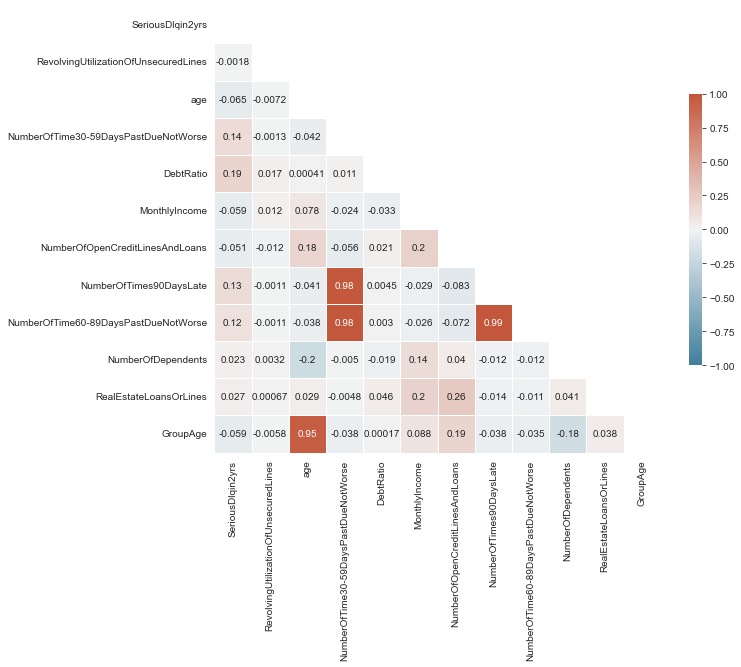

In [276]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           )
plt.show()

In [280]:
X_train_res.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents',
       'RealEstateLoansOrLines', 'GroupAge'],
      dtype='object')

In [287]:
rf_2.fit(X_train_res, y_train_res)
y_pred = rf_2.predict(X_test)

print_metrics(y_test, y_pred)

accuracy = 0.81
precision = 0.29
recall = 0.75
roc_auc = 0.78
f1 = 0.42


In [288]:
rf_3 = RandomForestClassifier(n_estimators = 646, max_depth = 19, criterion = 'entropy', min_samples_split = 101, 
                            min_samples_leaf = 15, random_state = 20)

rf_3.fit(X_train_res.drop(['GroupAge'], axis = 1), y_train_res)
y_pred = rf_3.predict(X_test.drop(['GroupAge'], axis = 1))

print_metrics(y_test, y_pred)

accuracy = 0.81
precision = 0.29
recall = 0.75
roc_auc = 0.78
f1 = 0.42


In [290]:
rf_3 = RandomForestClassifier(n_estimators = 646, max_depth = 19, criterion = 'entropy', min_samples_split = 101, 
                            min_samples_leaf = 15, random_state = 20)

rf_3.fit(X_train_res.drop(['age'], axis = 1), y_train_res)
y_pred = rf_3.predict(X_test.drop(['age'], axis = 1))

print_metrics(y_test, y_pred)

accuracy = 0.79
precision = 0.27
recall = 0.75
roc_auc = 0.77
f1 = 0.4


При отбросе признака 'age', качество модели немного упало. А при отбросе 'GroupAge' ничего не изменилось.

In [296]:
rf_3 = RandomForestClassifier(n_estimators = 646, max_depth = 19, criterion = 'entropy', min_samples_split = 101, 
                            min_samples_leaf = 15, random_state = 20)

rf_3.fit(X_train_res.drop(['NumberOfTime30-59DaysPastDueNotWorse'], axis = 1), y_train_res)
y_pred = rf_3.predict(X_test.drop(['NumberOfTime30-59DaysPastDueNotWorse'], axis = 1))

print_metrics(y_test, y_pred)

accuracy = 0.8
precision = 0.28
recall = 0.73
roc_auc = 0.77
f1 = 0.4


In [297]:
rf_3 = RandomForestClassifier(n_estimators = 646, max_depth = 19, criterion = 'entropy', min_samples_split = 101, 
                            min_samples_leaf = 15, random_state = 20)

rf_3.fit(X_train_res.drop(['NumberOfTime60-89DaysPastDueNotWorse'], axis = 1), y_train_res)
y_pred = rf_3.predict(X_test.drop(['NumberOfTime60-89DaysPastDueNotWorse'], axis = 1))

print_metrics(y_test, y_pred)

accuracy = 0.81
precision = 0.28
recall = 0.74
roc_auc = 0.78
f1 = 0.41


In [298]:
rf_3 = RandomForestClassifier(n_estimators = 646, max_depth = 19, criterion = 'entropy', min_samples_split = 101, 
                            min_samples_leaf = 15, random_state = 20)

rf_3.fit(X_train_res.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse'], axis = 1), y_train_res)
y_pred = rf_3.predict(X_test.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse'], axis = 1))

print_metrics(y_test, y_pred)

accuracy = 0.8
precision = 0.27
recall = 0.72
roc_auc = 0.76
f1 = 0.4


In [299]:
rf_3 = RandomForestClassifier(n_estimators = 646, max_depth = 19, criterion = 'entropy', min_samples_split = 101, 
                            min_samples_leaf = 15, random_state = 20)

rf_3.fit(X_train_res.drop(['GroupAge','NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse'], axis = 1), y_train_res)
y_pred = rf_3.predict(X_test.drop(['GroupAge', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse'], axis = 1))

print_metrics(y_test, y_pred)

accuracy = 0.8
precision = 0.27
recall = 0.72
roc_auc = 0.76
f1 = 0.39


Можно заметить, что несмотря на то, что некоторые признаки сильно коррелируют друг с другом, отброс любых фичей приводит к снижению качества модели. В связи с этим нужно отказаться от этой идеи.

<div id= 'id_6'/>

## Смешивание моделей Random Forest и CatBoost

Нам удалось выяснить, что наиболее оптимальным качеством модели обладают Random Forest и CatBoost. Попробуем смешать предсказания данных моделей в разных пропорциях, и посмотрим отразится ли это на качестве.

In [300]:
pred_rf = rf_2.predict(X_test)
pred_cat = cat_2.predict(X_test)

In [306]:
print_metrics(y_test, pred_rf)

accuracy = 0.81
precision = 0.29
recall = 0.75
roc_auc = 0.78
f1 = 0.42


In [307]:
print_metrics(y_test, pred_cat)

accuracy = 0.82
precision = 0.3
recall = 0.71
roc_auc = 0.77
f1 = 0.42


In [305]:
np.mean(pred_rf == pred_cat)

0.9409773060029283

Предсказания у 2-х моделей разные. Попробуем их смешать.

In [336]:
print_metrics(y_test, np.ceil((pred_rf + pred_cat)/2).astype('int64'))

accuracy = 0.79
precision = 0.27
recall = 0.77
roc_auc = 0.78
f1 = 0.4


In [341]:
print_metrics(y_test, np.round((pred_rf + pred_cat)/2).astype('int64'))

accuracy = 0.84
precision = 0.32
recall = 0.69
roc_auc = 0.77
f1 = 0.44


In [367]:
print_metrics(y_test, np.round(pred_rf * 0.4 + pred_cat * 0.6).astype('int64'))

accuracy = 0.82
precision = 0.3
recall = 0.71
roc_auc = 0.77
f1 = 0.42


Можно заметить, что смешивание подобным образом не дает особых результатов. Подмешивание модели CatBoost позволяет немного поднять метрику precision и accuricy, но в то же время метрика recall падает, однако f1 может незначительно вырасти. При этом округление "в потолок" позволяет немного поднять recall.

Попробуем подобрать гиперпараметры для модели CatBoost таким образом, чтобы максимизировать метрику precision и подмешать её к модели rf2.

In [368]:
def objective(trial):
    
    depth = trial.suggest_int("depth", 2, 16, log=True)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1, log=True)
    iterations = trial.suggest_int("iterations", 5, 150, log=True)
    
    cat_3 = CatBoostClassifier(depth=depth,
                            learning_rate=learning_rate,
                            iterations=iterations,
                            random_state = 20)
    

    score = cross_val_score(cat_3, X_train_res, y_train_res, n_jobs=-1, cv=5, scoring='precision')
    recision = score.mean()
    return recision


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
trial = study.best_trial

[I 2023-06-22 22:47:19,918] A new study created in memory with name: no-name-640346b7-dfc3-4f7e-8226-22e42a0b65b3
[I 2023-06-22 22:47:51,939] Trial 0 finished with value: 0.7854899734955006 and parameters: {'depth': 15, 'learning_rate': 0.008787756769425264, 'iterations': 33}. Best is trial 0 with value: 0.7854899734955006.
[I 2023-06-22 22:47:53,972] Trial 1 finished with value: 0.7467232354569264 and parameters: {'depth': 8, 'learning_rate': 0.006249178993464202, 'iterations': 5}. Best is trial 0 with value: 0.7854899734955006.
[I 2023-06-22 22:47:57,059] Trial 2 finished with value: 0.7159361370906037 and parameters: {'depth': 5, 'learning_rate': 0.0017219279187489485, 'iterations': 131}. Best is trial 0 with value: 0.7854899734955006.
[I 2023-06-22 22:48:25,150] Trial 3 finished with value: 0.7843721479509881 and parameters: {'depth': 15, 'learning_rate': 0.006032652922716376, 'iterations': 34}. Best is trial 0 with value: 0.7854899734955006.
[I 2023-06-22 22:48:25,749] Trial 4 fin

[I 2023-06-22 23:03:04,646] Trial 39 finished with value: 0.8226146835005622 and parameters: {'depth': 14, 'learning_rate': 0.07065923069949917, 'iterations': 149}. Best is trial 39 with value: 0.8226146835005622.
[I 2023-06-22 23:03:06,813] Trial 40 finished with value: 0.7871690009398576 and parameters: {'depth': 5, 'learning_rate': 0.04442183869543449, 'iterations': 121}. Best is trial 39 with value: 0.8226146835005622.
[I 2023-06-22 23:04:05,188] Trial 41 finished with value: 0.8182960376114551 and parameters: {'depth': 14, 'learning_rate': 0.06029721436087708, 'iterations': 147}. Best is trial 39 with value: 0.8226146835005622.
[I 2023-06-22 23:04:52,836] Trial 42 finished with value: 0.8166373588466882 and parameters: {'depth': 14, 'learning_rate': 0.06546517306229106, 'iterations': 120}. Best is trial 39 with value: 0.8226146835005622.
[I 2023-06-22 23:05:37,089] Trial 43 finished with value: 0.7927603187885116 and parameters: {'depth': 16, 'learning_rate': 0.03826169345879543, 

In [373]:
cat_3 = CatBoostClassifier(depth=16,
                            learning_rate=0.072766033746040,
                            iterations=145,
                            random_state = 20)

cat_3.fit(X_train_res, y_train_res)
pred_cat = cat_3.predict(X_test)

print_metrics(y_test, pred_cat)

0:	learn: 0.6655701	total: 662ms	remaining: 1m 35s
1:	learn: 0.6404506	total: 1.29s	remaining: 1m 32s
2:	learn: 0.6192834	total: 1.98s	remaining: 1m 33s
3:	learn: 0.5993940	total: 2.64s	remaining: 1m 33s
4:	learn: 0.5825223	total: 3.31s	remaining: 1m 32s
5:	learn: 0.5670644	total: 3.96s	remaining: 1m 31s
6:	learn: 0.5530393	total: 4.59s	remaining: 1m 30s
7:	learn: 0.5402596	total: 5.28s	remaining: 1m 30s
8:	learn: 0.5290828	total: 5.95s	remaining: 1m 29s
9:	learn: 0.5188759	total: 6.61s	remaining: 1m 29s
10:	learn: 0.5097892	total: 7.25s	remaining: 1m 28s
11:	learn: 0.5006750	total: 7.89s	remaining: 1m 27s
12:	learn: 0.4929325	total: 8.59s	remaining: 1m 27s
13:	learn: 0.4856522	total: 9.25s	remaining: 1m 26s
14:	learn: 0.4790709	total: 9.91s	remaining: 1m 25s
15:	learn: 0.4727842	total: 10.6s	remaining: 1m 25s
16:	learn: 0.4669471	total: 11.2s	remaining: 1m 24s
17:	learn: 0.4619962	total: 11.9s	remaining: 1m 23s
18:	learn: 0.4572478	total: 12.5s	remaining: 1m 23s
19:	learn: 0.4527152	t

In [374]:
print(classification_report(y_test, pred_cat))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89     29777
           1       0.30      0.72      0.42      3007

    accuracy                           0.82     32784
   macro avg       0.63      0.77      0.66     32784
weighted avg       0.91      0.82      0.85     32784



Можно заметить, что метрика precision всё равно по-прежнему низкая. Скорее всего никакой пользы от такого смешивания моделей не будет. Проверим это.

In [375]:
print_metrics(y_test, np.ceil((pred_rf + pred_cat)/2).astype('int64'))

accuracy = 0.79
precision = 0.28
recall = 0.77
roc_auc = 0.78
f1 = 0.41


In [376]:
print_metrics(y_test, np.round((pred_rf + pred_cat)/2).astype('int64'))

accuracy = 0.83
precision = 0.32
recall = 0.7
roc_auc = 0.77
f1 = 0.44


In [377]:
print_metrics(y_test, np.round(pred_rf * 0.4 + pred_cat * 0.6).astype('int64'))

accuracy = 0.82
precision = 0.3
recall = 0.72
roc_auc = 0.77
f1 = 0.42


In [381]:
print_metrics(y_test, np.ceil(pred_rf * 0.4 + pred_cat * 0.6).astype('int64'))

accuracy = 0.79
precision = 0.28
recall = 0.77
roc_auc = 0.78
f1 = 0.41


In [380]:
print_metrics(y_test, np.round(pred_rf * 0.6 + pred_cat * 0.4).astype('int64'))

accuracy = 0.81
precision = 0.29
recall = 0.75
roc_auc = 0.78
f1 = 0.42


In [382]:
print_metrics(y_test, np.ceil(pred_rf * 0.6 + pred_cat * 0.4).astype('int64'))

accuracy = 0.79
precision = 0.28
recall = 0.77
roc_auc = 0.78
f1 = 0.41


In [383]:
print_metrics(y_test, pred_rf)

accuracy = 0.81
precision = 0.29
recall = 0.75
roc_auc = 0.78
f1 = 0.42


Идея о смешивании моделей оказалась неудачной в данном случае, т.к. метрики меняются крайне незначительно. При этом реализация такой модели будет сложнее, чем несмешанная модель. В связи с этим в качестве лучшей модели будем использовать rf_2. У меня достаточно высокое значение метрик recall и accuricy, при этом precision тоже "ненулевой", хоть и достаточно низкий.

<div id= 'id_7'/>

## Попытка улучшения выбранной модели

Попробуем увеличить количество trials для random forest при подборе гиперпараметров для улучшения качества.

In [124]:
def objective(trial):

    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("max_depth", 2, 50, log=True)
    n_estimators = trial.suggest_int("n_estimators", 2, 1000)
    min_samples_split = trial.suggest_int("min_samples_split", 10, 500, step=1)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 500, step=1)

    rf_3 = RandomForestClassifier(criterion =criterion,
            max_depth=max_depth, 
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            min_samples_leaf = min_samples_leaf,
            random_state = 20
        )

    score = cross_val_score(rf_3, X_train_res, y_train_res, n_jobs=-1, cv=5, scoring='f1')
    f1 = score.mean()
    return f1


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
trial = study.best_trial

[I 2023-06-23 15:17:56,651] A new study created in memory with name: no-name-ed249151-eded-4dab-a39d-c01e6f7aaf0a
[I 2023-06-23 15:18:28,948] Trial 0 finished with value: 0.7921945392115621 and parameters: {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 319, 'min_samples_split': 52, 'min_samples_leaf': 341}. Best is trial 0 with value: 0.7921945392115621.
[I 2023-06-23 15:18:51,575] Trial 1 finished with value: 0.7752934218580514 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 619, 'min_samples_split': 494, 'min_samples_leaf': 283}. Best is trial 0 with value: 0.7921945392115621.
[I 2023-06-23 15:20:49,169] Trial 2 finished with value: 0.8009284043369211 and parameters: {'criterion': 'entropy', 'max_depth': 23, 'n_estimators': 899, 'min_samples_split': 427, 'min_samples_leaf': 123}. Best is trial 2 with value: 0.8009284043369211.
[I 2023-06-23 15:20:51,001] Trial 3 finished with value: 0.7693153540331007 and parameters: {'criterion': 'entropy', 'max_dept

[I 2023-06-23 16:01:27,950] Trial 32 finished with value: 0.8087272902303335 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 384, 'min_samples_split': 46, 'min_samples_leaf': 51}. Best is trial 22 with value: 0.816163850362372.
[I 2023-06-23 16:02:12,883] Trial 33 finished with value: 0.7920259398411221 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 413, 'min_samples_split': 46, 'min_samples_leaf': 381}. Best is trial 22 with value: 0.816163850362372.
[I 2023-06-23 16:02:50,529] Trial 34 finished with value: 0.8039634005689692 and parameters: {'criterion': 'entropy', 'max_depth': 23, 'n_estimators': 272, 'min_samples_split': 43, 'min_samples_leaf': 102}. Best is trial 22 with value: 0.816163850362372.
[I 2023-06-23 16:03:18,948] Trial 35 finished with value: 0.7917290934596142 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 288, 'min_samples_split': 96, 'min_samples_leaf': 39}. Best is trial 22 with value: 0.

[I 2023-06-23 16:37:06,168] Trial 65 finished with value: 0.8109570850595296 and parameters: {'criterion': 'entropy', 'max_depth': 37, 'n_estimators': 577, 'min_samples_split': 32, 'min_samples_leaf': 51}. Best is trial 63 with value: 0.8374385139292497.
[I 2023-06-23 16:38:17,957] Trial 66 finished with value: 0.8137179818518844 and parameters: {'criterion': 'entropy', 'max_depth': 43, 'n_estimators': 456, 'min_samples_split': 13, 'min_samples_leaf': 40}. Best is trial 63 with value: 0.8374385139292497.
[I 2023-06-23 16:39:43,423] Trial 67 finished with value: 0.8187287813726967 and parameters: {'criterion': 'gini', 'max_depth': 35, 'n_estimators': 636, 'min_samples_split': 27, 'min_samples_leaf': 28}. Best is trial 63 with value: 0.8374385139292497.
[I 2023-06-23 16:41:06,740] Trial 68 finished with value: 0.8085517346591775 and parameters: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 565, 'min_samples_split': 10, 'min_samples_leaf': 64}. Best is trial 63 with value: 0.8

[I 2023-06-23 17:22:41,442] Trial 98 finished with value: 0.8127163997498809 and parameters: {'criterion': 'entropy', 'max_depth': 29, 'n_estimators': 425, 'min_samples_split': 18, 'min_samples_leaf': 43}. Best is trial 63 with value: 0.8374385139292497.
[I 2023-06-23 17:24:26,506] Trial 99 finished with value: 0.8146876239532623 and parameters: {'criterion': 'entropy', 'max_depth': 45, 'n_estimators': 660, 'min_samples_split': 96, 'min_samples_leaf': 33}. Best is trial 63 with value: 0.8374385139292497.


In [125]:
%%time

rf_3 = RandomForestClassifier(n_estimators = 576, max_depth = 37, criterion = 'entropy', min_samples_split = 11, 
                            min_samples_leaf = 10, random_state = 20)
rf_3.fit(X_train_res, y_train_res)
y_pred = rf_3.predict(X_test)

print_metrics(y_test, y_pred)

accuracy = 0.83
precision = 0.31
recall = 0.71
roc_auc = 0.78
f1 = 0.44
CPU times: total: 1min 40s
Wall time: 1min 48s


In [126]:
print_metrics(y_test, y_pred)

accuracy = 0.83
precision = 0.31
recall = 0.71
roc_auc = 0.78
f1 = 0.44


Для модели rf_2 метрика всё же была выше, остальные метрики приблизительно такие же (не отличаются глобально). Ниже приведены результаты модели rf_2:

accuracy = 0.81
precision = 0.29
recall = 0.75
roc_auc = 0.78
f1 = 0.42

<div id= 'id_8'/>

## Вывод

В качестве лучшей модели для дальнейшего построения web-сервиса будем использовать модель rf_2. Сохраним модель в формат pickle.

In [123]:
import pickle

In [124]:
with open('model.pickle', 'wb') as f:
    pickle.dump(rf_2, f)

Проверим, что всё выполнено корректно, и загруженная модель даст те же предсказания.

In [128]:
with open('model.pickle', 'rb') as f:
    model = pickle.load(f)

y_pred_1 = model.predict(X_test)
print_metrics(y_test, y_pred_1)

accuracy = 0.81
precision = 0.29
recall = 0.75
roc_auc = 0.78
f1 = 0.42
